# ARGs in Metagenomes 

## Calculation: rwi bwt



Caveat: this is an experimental feature of CARD's resistant gene identifier

Not clear how to cleanly separate hits from non-hits 

WildCARD not included

Command: `rgi bwt --read_one AFY01_1.fastq.gz --read_two AFY01_2.fastq.gz --aligner bowtie2 --output_file AFY01 --threads 30 --local`



In [1]:
!pwd

/home/ahenschel/AMG_Metagenomes_AhmedY/ResistomeComparison


In [2]:
from bokeh.palettes import Category20c
from bokeh.plotting import figure, show
from bokeh.transform import cumsum
from bokeh.models import LinearColorMapper, ColorBar, BasicTicker, PrintfTickFormatter
from bokeh.io import output_notebook
output_notebook()
import seaborn as sns

from math import pi
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 20]

import pandas as pd
pd.set_option("display.max_columns", None)
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Loading BokehJS ...

In [32]:
#sampleIDs = '01 11 13 16'.split() ## samples with Resistomap data
sampleIDs = '01 03 04 07 10 11 13 14 15 16 17 18 19 20 22 99'.split()
#sampleIDs = ['99']
def loadDF(sid, mapqThr = 10, pCovThr = 90, mappedReadThr = 10):
    gene = pd.read_csv(f'NoWildAFY{sid}.gene_mapping_data.txt', sep='\t')
    gene['Reference Length'] = [int(rl.split(';')[0]) for rl in gene['Reference Length']]
    gene['coverage'] = 150*gene['Completely Mapped Reads'].div(gene['Reference Length'])  
    gene["relAb"] = 100*gene.coverage/gene.coverage.sum()
    # QC
    geneQC = gene[(gene['Average MAPQ (Completely Mapped Reads)'] > mapqThr) & (gene['Average Percent Coverage'] > pCovThr) & (gene['Completely Mapped Reads'] > mappedReadThr)]
    return geneQC

def extractHeatmapData2(sid, col='Drug Class', mapqThr = 10, pCovThr = 90, mappedReadThr = 10):
    geneQC = loadDF(sid, mapqThr=mapqThr, pCovThr=pCovThr, mappedReadThr=mappedReadThr)
    return Counter(geneQC[col])

def extractHeatmapData(sid, col1='ARO Term', col2='Completely Mapped Reads', mapqThr = 10, pCovThr = 90, mappedReadThr = 10, log=False):
    geneQC = loadDF(sid, mapqThr=mapqThr, pCovThr=pCovThr, mappedReadThr=mappedReadThr)
    if log:
        geneQC[col2] = np.log(geneQC[col2])
    return dict(zip(geneQC[col1], geneQC[col2]))

def interactiveHeatmap(df, xrange, yrange, width=3000, height=600, val='reads', title="Reads/ARGs per sample"):
    colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
    mapper = LinearColorMapper(palette=colors, low=df[val].min(), high=df[val].max())

    TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

    p = figure(title=title,
               x_range=xrange, y_range=yrange,
               x_axis_location="above", width=width, height=height,
               tools=TOOLS, toolbar_location='below',
               tooltips=[('sample', '@ARG @sample'), (val, f'@{val}')])

    p.grid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "10px"
    p.axis.major_label_standoff = 0
    p.xaxis.major_label_orientation = pi / 3

    p.rect(x="ARG", y="sample", width=1, height=1,
           source=df,
           fill_color={'field': val, 'transform': mapper},
           line_color=None)

    color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="7px",
                         ticker=BasicTicker(desired_num_ticks=len(colors)),
                         formatter=PrintfTickFormatter(format="%d"),
                         label_standoff=6, border_line_color=None)
    p.add_layout(color_bar, 'right')
    show(p)

In [202]:
summary = pd.DataFrame([extractHeatmapData(sid, col1='ARO Accession', col2='coverage', mapqThr=0, pCovThr = 95) for sid in sampleIDs]).T
summary.head()

0           1           2          3
3002867    9.393939    6.060606    6.363636        NaN
3002372    4.500000         NaN    4.166667        NaN
3002835    8.024691         NaN         NaN        NaN
3001800    8.695652         NaN    6.702899        NaN
3003109  252.134146  100.406504  394.308943  21.544715

In [203]:
sid = '01'
cols = [0,1,23,24,25]
infoTable = None
for sid in sampleIDs:
    gene = pd.read_csv(f'NoWildAFY{sid}.gene_mapping_data.txt', sep='\t')
    gene = gene.iloc[:,cols].set_index('ARO Accession')    
    if infoTable is None: infoTable = gene
    else:
        gene = gene[~gene.index.isin(set(infoTable.index))]
        infoTable = pd.concat([infoTable, gene], axis=0)
    print(infoTable.shape)
infoTable.head(3)

(1290, 4)
(1484, 4)
(1698, 4)
(1726, 4)


ARO Term                                    AMR Gene Family  \
ARO Accession                                                               
3002999         CblA-1                                CblA beta-lactamase   
3002867           dfrF  trimethoprim resistant dihydrofolate reductase...   
3002244         CARB-5                                CARB beta-lactamase   

                                 Drug Class           Resistance Mechanism  
ARO Accession                                                               
3002999                       cephalosporin        antibiotic inactivation  
3002867        diaminopyrimidine antibiotic  antibiotic target replacement  
3002244                               penam        antibiotic inactivation

In [204]:
readsPsample = {'AFY01': 85893508, 'AFY11': 78593058, 'AFY13': 82806922, 'AFY16': 79518594}

s01 = loadDF('01')
s01.head(3)

ARO Term  ARO Accession   Reference Model Type Reference DB  \
1     dfrF        3002867  protein homolog model         CARD   
6     lnuA        3002835  protein homolog model         CARD   
9     msrE        3003109  protein homolog model         CARD   

   Alleles with Mapped Reads  \
1                          1   
6                          1   
9                          1   

   Reference Allele(s) Identity to CARD Reference Protein (%)  \
1                                              100.0            
6                                              100.0            
9                                              100.0            

  Resistomes & Variants: Observed in Genome(s)  \
1                                      no data   
6                                      no data   
9                                      no data   

  Resistomes & Variants: Observed in Plasmid(s)  \
1                                       no data   
6                                       no data   
9                                       no data   

  Resistomes & Variants: Observed Pathogen(s)  Completely Mapped Reads  \
1                       Enterococcus faecalis                     31.0   
6                 Staphylococcus haemolyticus                     26.0   
9                     Acinetobacter baumannii                   2481.0   

   Mapped Reads with Flanking Sequence  All Mapped Reads  \
1                                 25.0              56.0   
6                                 16.0              42.0   
9                                309.0            2790.0   

   Average Percent Coverage  Average Length Coverage (bp)  \
1                     100.0                         495.0   
6                     100.0                         486.0   
9                     100.0                        1476.0   

   Average MAPQ (Completely Mapped Reads)  Number of Mapped Baits  \
1                                   21.91                       0   
6                                   24.71                       0   
9                                   38.08                       0   

   Number of Mapped Baits with Reads  Average Number of reads per Bait  \
1                                  0                                 0   
6                                  0                                 0   
9                                  0                                 0   

   Number of reads per Bait Coefficient of Variation (%)  \
1                                                  0       
6                                                  0       
9                                                  0       

   Number of reads mapping to baits and mapping to complete gene  \
1                                                NaN               
6                                                NaN               
9                                                NaN               

   Number of reads mapping to baits and mapping to complete gene (%)  \
1                                                NaN                   
6                                                NaN                   
9                                                NaN                   

  Mate Pair Linkage (# reads)  Reference Length  \
1                         NaN               495   
6                         NaN               486   
9        tet(C) (1); mphE (1)              1476   

                                     AMR Gene Family  \
1  trimethoprim resistant dihydrofolate reductase...   
6           lincosamide nucleotidyltransferase (LNU)   
9                             msr-type ABC-F protein   

                                       Drug Class  \
1                    diaminopyrimidine antibiotic   
6                          lincosamide antibiotic   
9  macrolide antibiotic; streptogramin antibiotic   

            Resistance Mechanism    coverage     relAb  
1  antibiotic target replacement    9.393939  0.021863  
6        antibiotic inactiva

## Heatmap for Drug Class

In [5]:
#extractHeatmapData2(sid)
heatmap = pd.DataFrame([extractHeatmapData2(sid, col='Drug Class', mapqThr=0, pCovThr = 95) for sid in sampleIDs]).transpose()
heatmap.columns = samples = [f'AFY{sid}' for sid in sampleIDs]

# filter low abundance
heatmap['max'] = heatmap.max(axis=1)
heatmap2=heatmap[heatmap['max']>3].iloc[:,:-1]

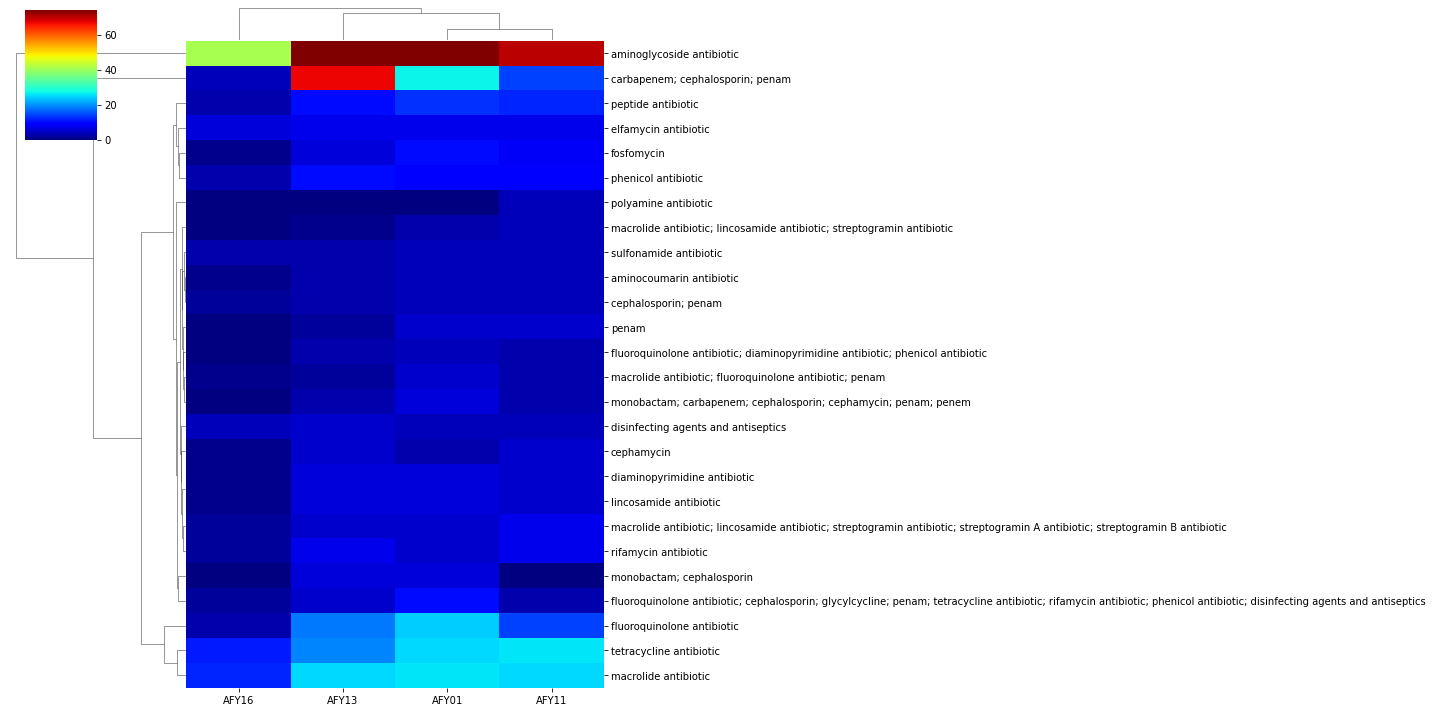

In [6]:
hm = sns.clustermap(heatmap2.fillna(0), figsize=(20,10), dendrogram_ratio=(0.3,.05), cmap='jet') #, cbar_pos=(0,0.2,0.05,0.18), linewidths=0.5)
#for ax in hm.fig.axes:
#    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#plt.xticks(rotation=90)
#hm.set_xticklabels(rotation=90)

In [7]:
hm.savefig('Heatmap_for_Drug_Class.svg')

## Heatmap for AMR Gene family

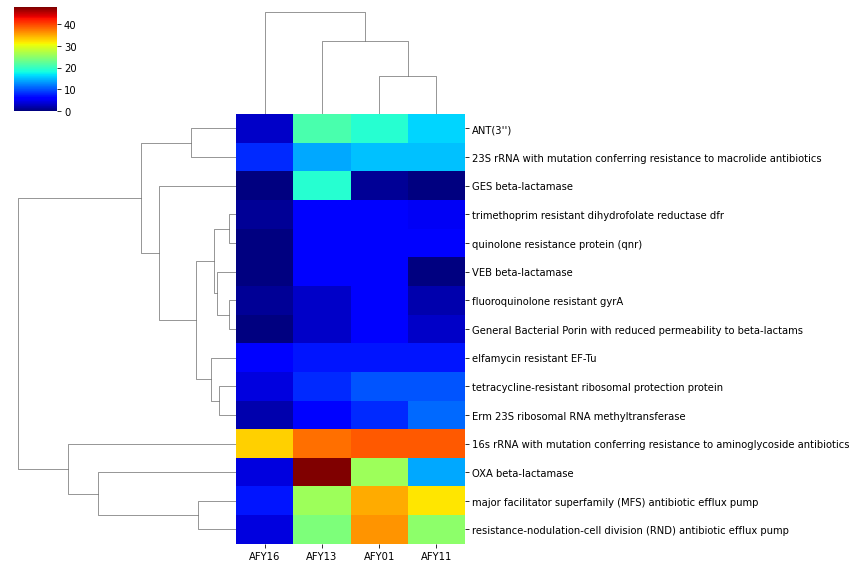

In [70]:
heatmap = pd.DataFrame([extractHeatmapData2(sid, col='AMR Gene Family', mapqThr=0, pCovThr = 95) for sid in sampleIDs]).transpose()
heatmap.columns = samples = [f'AFY{sid}' for sid in sampleIDs]
heatmap['max'] = heatmap.max(axis=1)
heatmap2=heatmap[heatmap['max']>5].iloc[:,:-1]
hm = sns.clustermap(heatmap2.fillna(0), figsize=(12,8), dendrogram_ratio=(0.5,.2), cmap='jet')

In [72]:
hm.savefig('Heatmap_for_AMR_Gene_family.svg')

In [69]:
fig.savefig('Heatmap_for_AMR_Gene_family.svg')

## Vancomycin, Neisseria, Helicobacter
Selecting and plotting Xfold coverage

In [49]:
heatmap = pd.DataFrame([extractHeatmapData(sid, col2='coverage', mapqThr=0, pCovThr = 50, mappedReadThr=0, log=False) for sid in sampleIDs]).transpose()

heatmap.columns = samples = [f'AFY{sid}' for sid in sampleIDs]
heatmapVanco = heatmap[heatmap.index.str.contains("van")]
heatmapVanco

AFY01      AFY11  \
Clostridioides difficile rpoC with mutation con...  63.253012  33.864028   
vanR gene in vanO cluster                            7.692308  26.282051   
vanR gene in vanI cluster                                 NaN   1.287554   
vanS gene in vanO cluster                                 NaN        NaN   

                                                        AFY13     AFY16  
Clostridioides difficile rpoC with mutation con...  27.667814  4.776248  
vanR gene in vanO cluster                           14.529915  6.196581  
vanR gene in vanI cluster                                 NaN       NaN  
vanS gene in vanO cluster                            3.468208  2.312139

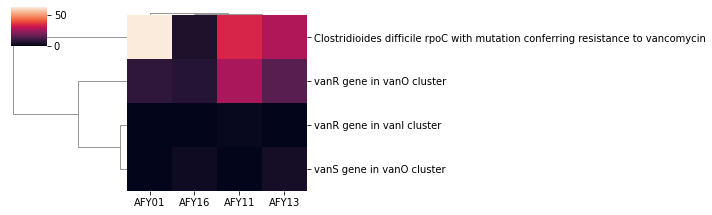

In [52]:
hm = sns.clustermap(heatmapVanco.fillna(0), figsize=(10,3), dendrogram_ratio=(0.4,.01))
#for ax in hm.fig.axes:
#    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [50]:
heatmapBif = heatmap[heatmap.index.str.contains("Helico")]
heatmapBif
#heatmap2 = heatmap[heatmap.index.str.contains("Neisseria")]
#.loc['Neisseria gonorrhoeae rpld']

AFY01        AFY11  \
Helicobacter pylori 16S rRNA mutation conferrin...  4835.876083  1972.784810   
Helicobacter pylori 23S rRNA with mutation conf...  1311.428571   505.613445   

                                                          AFY13       AFY16  
Helicobacter pylori 16S rRNA mutation conferrin...  1354.197202  274.217189  
Helicobacter pylori 23S rRNA with mutation conf...   319.915966   72.201681

In [66]:
heatmap = pd.DataFrame([extractHeatmapData(sid, 'ARO Term', 'Average Percent Coverage', mapqThr=0, pCovThr = 95) for sid in sampleIDs]).transpose()
heatmap.columns = samples = [f'AFY{sid}' for sid in sampleIDs]
args = list(heatmap.index)

In [67]:
!pwd

/home/ahenschel/AMG_Metagenomes_AhmedY/ResistomeComparison


In [60]:
df = pd.DataFrame(heatmap.stack()).reset_index()
columns = ['ARG', 'sample', 'coverage']
df.columns = columns
df = df.sort_values('ARG')
#df['reads'] = np.log(df['reads'])

interactiveHeatmap(df, args, samples, val='coverage')

NameError: name 'args' is not defined

In [ ]:
heatmap

## antibiotic statistics

In [70]:
drug = pd.DataFrame([extractHeatmapData2(sid) for sid in sampleIDs])
drug.index = sampleIDs
drug

diaminopyrimidine antibiotic  lincosamide antibiotic  \
01                             5                     4.0   
11                             5                     3.0   
13                             6                     4.0   
16                             1                     NaN   

    macrolide antibiotic; streptogramin antibiotic  fosfomycin  \
01                                               2           7   
11                                               2           6   
13                                               2           6   
16                                               2           1   

    nucleoside antibiotic; disinfecting agents and antiseptics  \
01                                                  3            
11                                                  3            
13                                                  2            
16                                                  1            

    macrolide antibiotic; fluoroquinolone antibiotic; penam  \
01                                                  5         
11                                                  4         
13                                                  2         
16                                                  1         

    aminoglycoside antibiotic  phenicol antibiotic  \
01                         21                    7   
11                         20                    6   
13                         19                    6   
16                          7                    2   

    aminoglycoside antibiotic; aminocoumarin antibiotic  cephamycin  \
01                                                  3             1   
11                                                  3             1   
13                                                  1             1   
16                                                  1             1   

    fluoroquinolone antibiotic  aminocoumarin antibiotic  \
01                          15                         4   
11                          12                         3   
13                          14                         3   
16                           7                         1   

    tetracycline antibiotic  \
01                       22   
11                       21   
13                       15   
16                        9   

    macrolide antibiotic; lincosamide antibiotic; streptogramin antibiotic; streptogramin A antibiotic; streptogramin B antibiotic  \
01                                                  6                                                                                
11                                                  7                                                                                
13                                                  6                                                                                
16                                                  2                                                                                

    peptide antibiotic  \
01                   9   
11                   8   
13                   7   
16                   2   

    fluoroquinolone antibiotic; cephalosporin; glycylcycline; cephamycin; penam; tetracycline antibiotic; rifamycin antibiotic; phenicol antibiotic; disinfecting agents and antiseptics  \
01                                                1.0                                                                                                                                      
11                                                1.0                                                                                                                                      
13                                                NaN                                                                                                                                      
16                                                NaN                                  

In [71]:
drug1 = drug.transpose()
drugcount = pd.DataFrame(drug1.sum(axis=1), columns=['count'])
drugcount.sort_values(by='count', ascending=False).head(50)

count
aminoglycoside antibiotic                            67.0
tetracycline antibiotic                              67.0
macrolide antibiotic                                 58.0
fluoroquinolone antibiotic                           48.0
peptide antibiotic                                   26.0
phenicol antibiotic                                  21.0
fluoroquinolone antibiotic; cephalosporin; glyc...   21.0
macrolide antibiotic; lincosamide antibiotic; s...   21.0
fosfomycin                                           20.0
diaminopyrimidine antibiotic                         17.0
rifamycin antibiotic                                 17.0
carbapenem; cephalosporin; penam                     16.0
sulfonamide antibiotic                               16.0
monobactam; carbapenem; cephalosporin; cephamyc...   14.0
disinfecting agents and antiseptics                  14.0
elfamycin antibiotic                                 13.0
macrolide antibiotic; fluoroquinolone antibioti...   12.0
aminocoumarin antibiotic                             11.0
macrolide antibiotic; lincosamide antibiotic; s...   11.0
lincosamide antibiotic                               11.0
fluoroquinolone antibiotic; diaminopyrimidine a...   11.0
isoniazid                                            10.0
nucleoside antibiotic; disinfecting agents and ...    9.0
penam                                                 8.0
macrolide antibiotic; streptogramin antibiotic        8.0
aminoglycoside antibiotic; aminocoumarin antibi...    8.0
glycopeptide antibiotic                               7.0
fluoroquinolone antibiotic; glycylcycline; tetr...    6.0
macrolide antibiotic; peptide antibiotic              6.0
oxazolidinone antibiotic                              6.0
cephalosporin; penam                                  6.0
fluoroquinolone antibiotic; cephalosporin; ceph...    6.0
Para-aminosalicylic acid                              5.0
fluoroquinolone antibiotic; monobactam; carbape...    4.0
mupirocin                                             4.0
cephamycin                                            4.0
pyrazinamide                                          4.0
tetracycline antibiotic; disinfecting agents an...    4.0
cephalosporin; penam; penem                           4.0
macrolide antibiotic; fluoroquinolone antibioti...    4.0
macrolide antibiotic; penam                           4.0
carbapenem; cephalosporin                             4.0
macrolide antibiotic; monobactam; tetracycline ...    3.0
macrolide antibiotic; aminoglycoside antibiotic...    3.0
macrolide antibiotic; fluoroquinolone antibioti...    3.0
macrolide antibiotic; fluoroquinolone antibioti...    3.0
carbapenem; peptide antibiotic; aminocoumarin a...    3.0
fluoroquinolone antibiotic; tetracycline antibi...    3.0
isoniazid; disinfecting agents and antiseptics        3.0
nitrofuran antibiotic                                 3.0

In [72]:
c = Counter()
for d in drug.columns.values:
    c+= Counter([e.strip()for e in d.split(';')])
c.most_common()

[('fluoroquinolone antibiotic', 21),
 ('macrolide antibiotic', 20),
 ('penam', 19),
 ('tetracycline antibiotic', 19),
 ('cephalosporin', 18),
 ('disinfecting agents and antiseptics', 12),
 ('phenicol antibiotic', 12),
 ('cephamycin', 10),
 ('carbapenem', 9),
 ('aminoglycoside antibiotic', 8),
 ('aminocoumarin antibiotic', 8),
 ('peptide antibiotic', 8),
 ('rifamycin antibiotic', 8),
 ('penem', 7),
 ('diaminopyrimidine antibiotic', 6),
 ('glycylcycline', 6),
 ('monobactam', 6),
 ('lincosamide antibiotic', 5),
 ('streptogramin antibiotic', 3),
 ('nucleoside antibiotic', 3),
 ('sulfonamide antibiotic', 3),
 ('isoniazid', 3),
 ('nitrofuran antibiotic', 2),
 ('fosfomycin', 1),
 ('streptogramin A antibiotic', 1),
 ('streptogramin B antibiotic', 1),
 ('elfamycin antibiotic', 1),
 ('polyamine antibiotic', 1),
 ('nitroimidazole antibiotic', 1),
 ('glycopeptide antibiotic', 1),
 ('Para-aminosalicylic acid', 1),
 ('Zoliflodacin', 1),
 ('oxazolidinone antibiotic', 1),
 ('mupirocin', 1),
 ('fusidic

## Heatmap: coverage per ARG

## Heatmap: Mapped Reads per ARG
different QC filters applied

In [73]:
heatmap = pd.DataFrame([extractHeatmapData(sid, 'ARO Term', 'Completely Mapped Reads', mapqThr=20) for sid in sampleIDs]).transpose()
heatmap.columns = samples = [f'AFY{sid}' for sid in sampleIDs]
heatmap.sort_index()

AFY01  AFY11  AFY13  \
23S rRNA (adenine(2058)-N(6))-methyltransferase...     NaN   37.0    NaN   
AAC(6')-IIa                                           15.0    NaN   49.0   
AAC(6')-Ie-APH(2'')-Ia                               123.0  253.0   31.0   
ACI-1                                                271.0  179.0   26.0   
AER-1                                                 24.0   17.0  201.0   
...                                                    ...    ...    ...   
tetO                                                1061.0  832.0  315.0   
tetQ                                                 491.0  387.0  252.0   
tetR                                                  19.0    NaN    NaN   
tetS                                                 188.0  113.0    NaN   
ugd                                                   65.0    NaN    NaN   

                                                    AFY16  
23S rRNA (adenine(2058)-N(6))-methyltransferase...    NaN  
AAC(6')-IIa                                           NaN  
AAC(6')-Ie-APH(2'')-Ia                                NaN  
ACI-1                                                19.0  
AER-1                                                 NaN  
...                                                   ...  
tetO                                                 53.0  
tetQ                                                120.0  
tetR                                                  NaN  
tetS                                                  NaN  
ugd                                                   NaN  

[170 rows x 4 columns]

In [74]:
args = list(heatmap.index)

df = pd.DataFrame(heatmap.stack()).reset_index()
columns = ['ARG', 'sample', 'reads']
df.columns = columns
df['reads'] = np.log(df['reads'])
    
interactiveHeatmap(df, args, samples)


In [75]:
df.sort_values('ARG')

ARG sample     reads
405  23S rRNA (adenine(2058)-N(6))-methyltransferas...  AFY11  3.610918
192                                        AAC(6')-IIa  AFY13  3.891820
191                                        AAC(6')-IIa  AFY01  2.708050
206                             AAC(6')-Ie-APH(2'')-Ia  AFY11  5.533389
207                             AAC(6')-Ie-APH(2'')-Ia  AFY13  3.433987
..                                                 ...    ...       ...
118                                               tetQ  AFY13  5.529429
38                                                tetR  AFY01  2.944439
180                                               tetS  AFY01  5.236442
181                                               tetS  AFY11  4.727388
86                                                 ugd  AFY01  4.174387

[414 rows x 3 columns]

## Extending comparison to 15 samples

In [ ]:
sampleIDs = '01 03 04 07 10 11 13 14 15 16 17 18 19 20 22'.split()
heatmap = pd.DataFrame([extractHeatmapData(sid, 'ARO Term', 'Completely Mapped Reads') for sid in sampleIDs]).transpose()
heatmap.columns = samples = [f'AFY{sid}' for sid in sampleIDs]
fig, ax = plt.subplots(1, figsize=(35, 50))
sns.heatmap(heatmap, annot=True, ax=ax)

['23S rRNA (adenine(2058)-N(6))-methyltransferase Erm(A)', "AAC(2')-Ib", "AAC(2')-Ic", "AAC(6')-IIa", "AAC(6')-Ib7", "AAC(6')-Ie-APH(2'')-Ia", 'ACI-1', 'AER-1', 'AIM-1', "ANT(2'')-Ia", "ANT(3'')-IIa", "ANT(3'')-IIc", "ANT(4')-Ib", 'ANT(6)-Ia', 'ANT(6)-Ib', 'ANT(9)-Ia', "APH(3'')-Ib", "APH(3'')-Ic", "APH(3')-IIIa", "APH(3')-Ia", "APH(3')-Ib", 'APH(6)-Id', 'Acinetobacter baumannii gyrA conferring resistance to fluoroquinolones', 'AcrE', 'AcrF', 'AcrS', 'ArnT', 'AxyX', 'BES-1', 'Bifidobacterium adolescentis rpoB mutants conferring resistance to rifampicin', 'Bifidobacterium bifidum ileS conferring resistance to mupirocin', 'Burkholderia dolosa gyrA conferring resistance to fluoroquinolones', 'CRP', 'Campylobacter coli chloramphenicol acetyltransferase', 'Campylobacter jejuni 23S rRNA with mutation conferring resistance to erythromycin', 'CblA-1', 'CfxA6', 'Chlamydia trachomatis 23S rRNA with mutation conferring resistance to macrolide antibiotics', 'Clostridioides difficile 23S rRNA with 

In [38]:
%pprint

Pretty printing has been turned OFF


In [40]:
df = pd.DataFrame(heatmap.stack()).reset_index()
columns = ['ARG', 'sample', 'reads']
df.columns = columns
df['reads'] = np.log(df['reads'])
    
interactiveHeatmap(df, args, samples)

<AxesSubplot:>

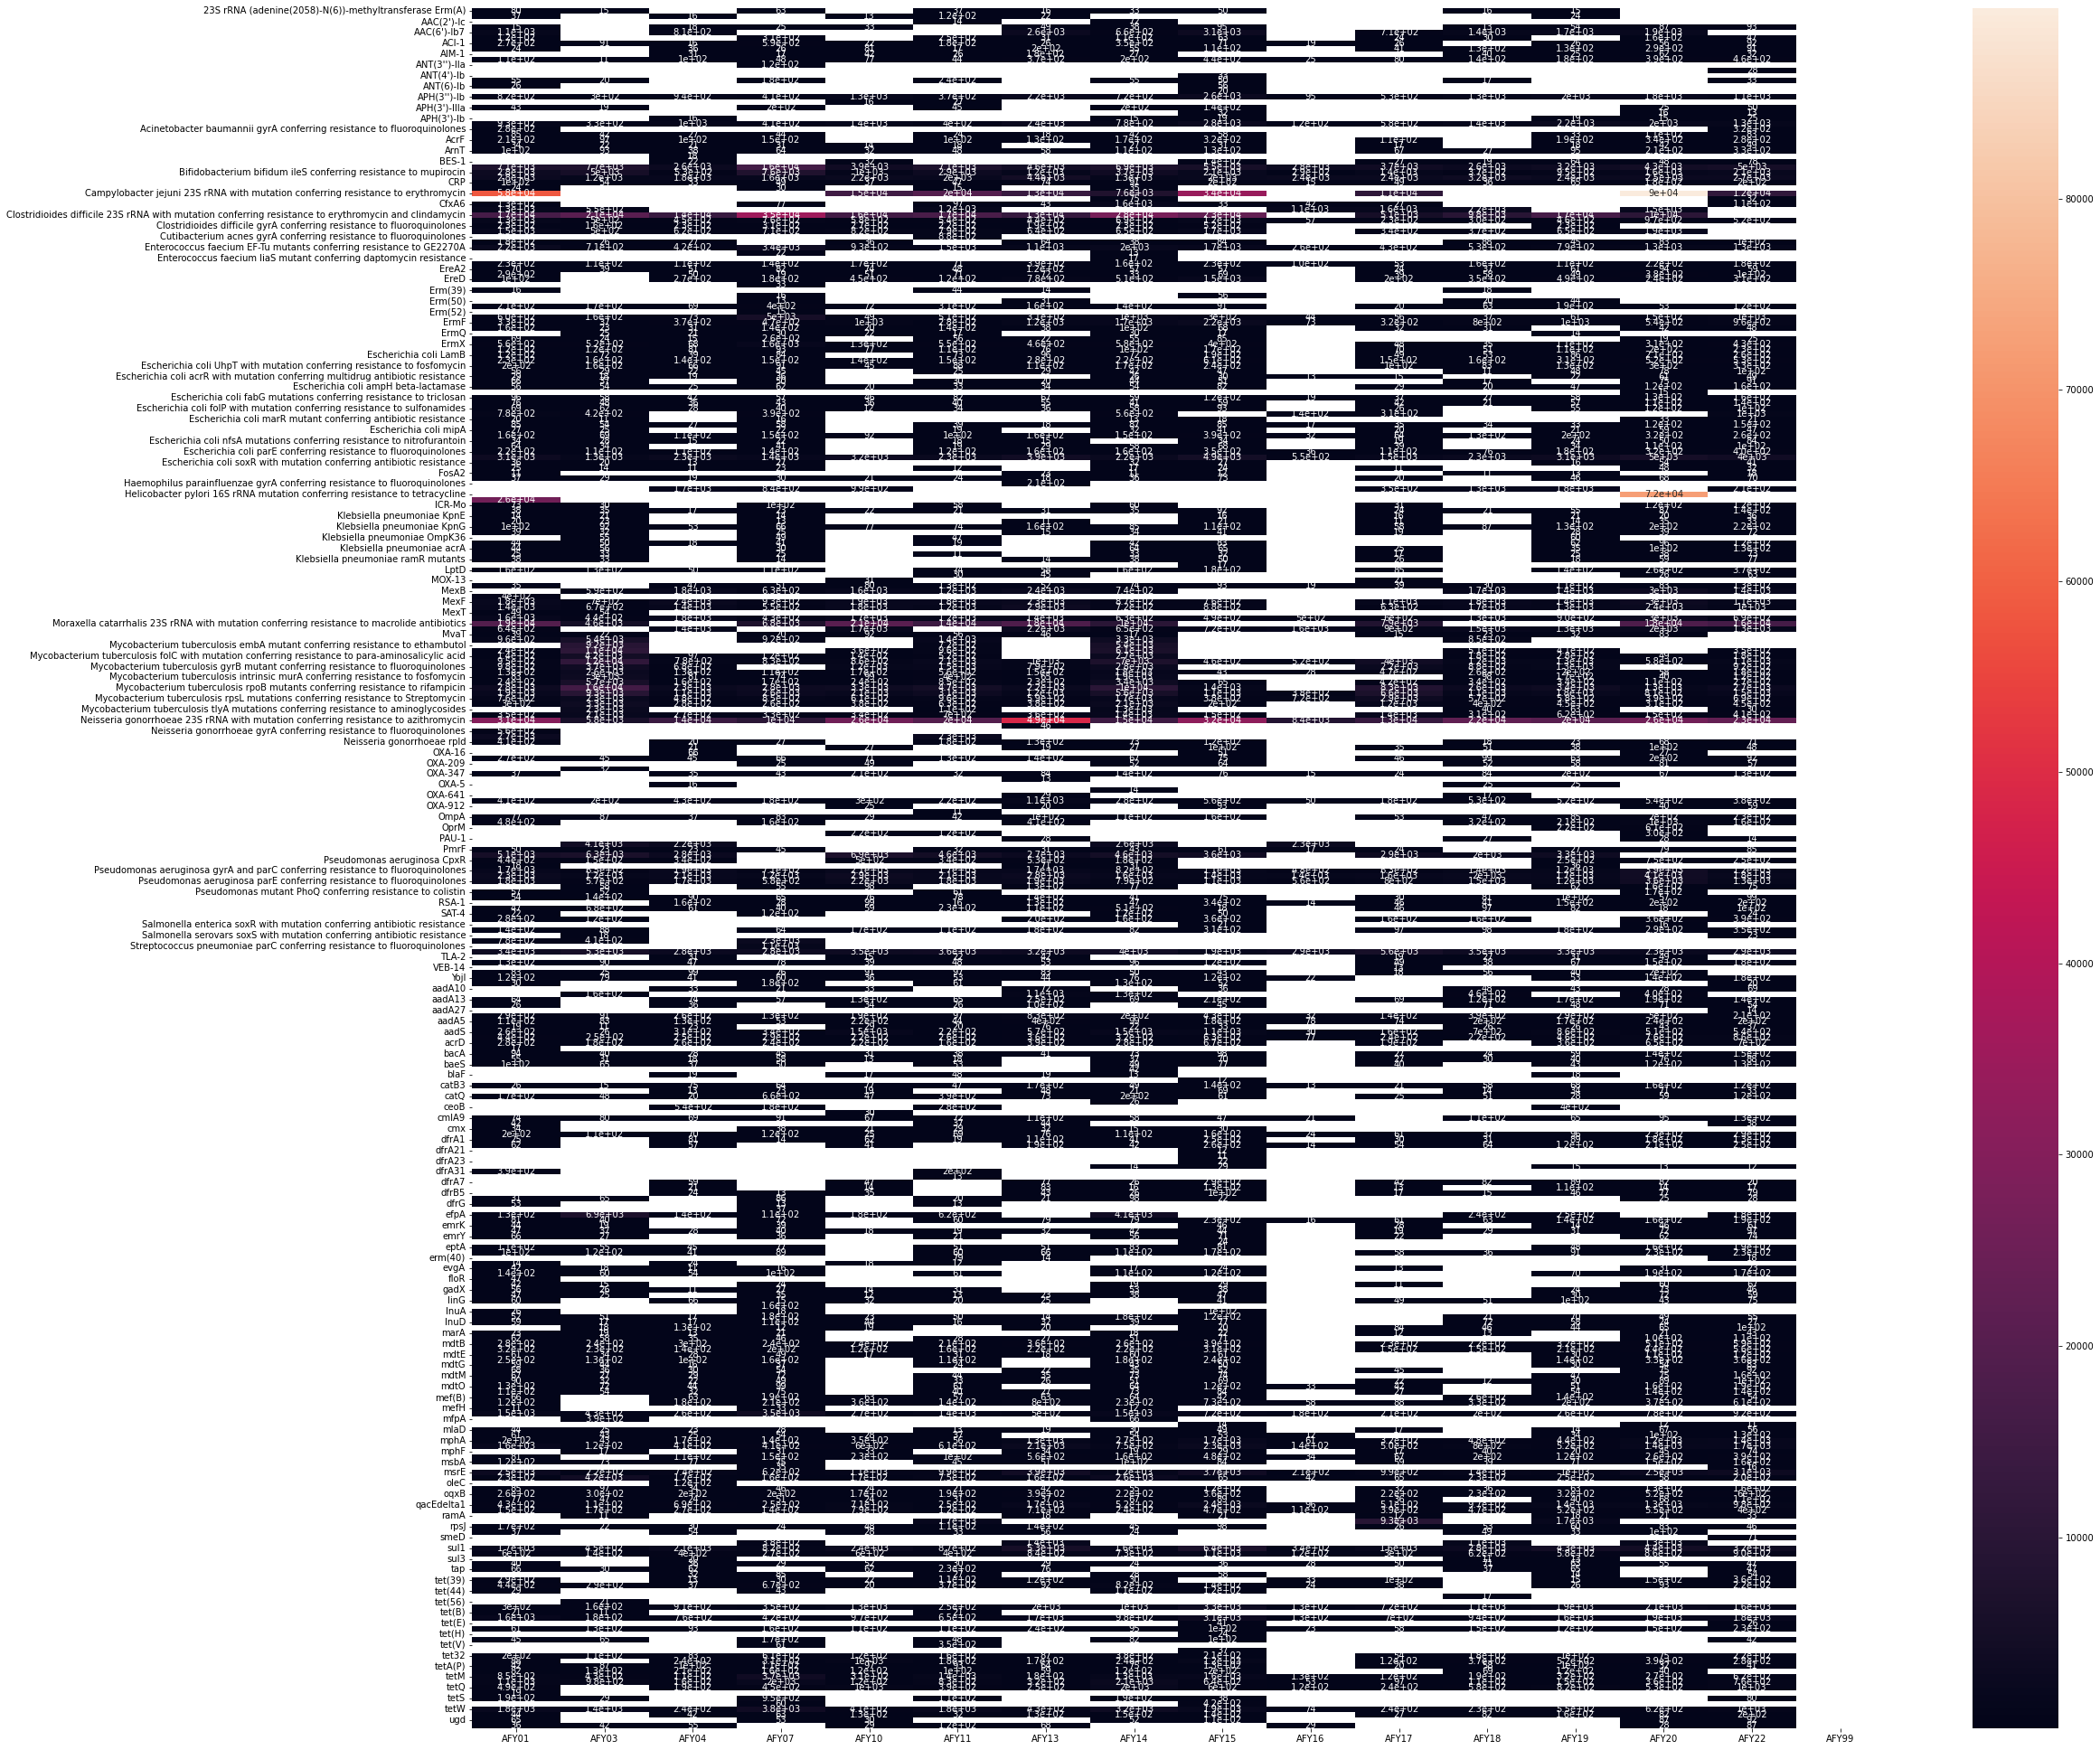

In [48]:
heatmap = heatmap.loc[sorted(heatmap.index)]
fig, ax = plt.subplots(1, figsize=(35, 35))
sns.heatmap(heatmap, annot=True, ax=ax)

AFY01   AFY03  AFY04  \
23S rRNA (adenine(2058)-N(6))-methyltransferase...    80.0    15.0    NaN   
AAC(2')-Ib                                            37.0     NaN   16.0   
AAC(2')-Ic                                             NaN     NaN    NaN   
AAC(6')-IIa                                           15.0     NaN   18.0   
AAC(6')-Ib7                                         1146.0     NaN  812.0   
...                                                    ...     ...    ...   
tetT                                                   NaN     NaN    NaN   
tetW                                                1806.0  1444.0  235.0   
tetX                                                  44.0     NaN   42.0   
ugd                                                   65.0     NaN    NaN   
vanR gene in vanO cluster                             36.0    42.0   55.0   

                                                     AFY07  AFY10   AFY11  \
23S rRNA (adenine(2058)-N(6))-methyltransferase...    63.0    NaN    37.0   
AAC(2')-Ib                                             NaN   13.0   118.0   
AAC(2')-Ic                                             NaN    NaN    14.0   
AAC(6')-IIa                                           25.0   33.0     NaN   
AAC(6')-Ib7                                            NaN    NaN     NaN   
...                                                    ...    ...     ...   
tetT                                                  60.0    NaN     NaN   
tetW                                                3815.0  412.0  1755.0   
tetX                                                  63.0  129.0    32.0   
ugd                                                   53.0   30.0     NaN   
vanR gene in vanO cluster                              NaN   29.0   123.0   

                                                     AFY13   AFY14   AFY15  \
23S rRNA (adenine(2058)-N(6))-methyltransferase...    16.0    33.0    50.0   
AAC(2')-Ib                                            22.0     NaN     NaN   
AAC(2')-Ic                                             NaN    72.0     NaN   
AAC(6')-IIa                                           49.0    38.0    95.0   
AAC(6')-Ib7                                         2586.0   661.0  3120.0   
...                                                    ...     ...     ...   
tetT                                                   NaN     NaN   421.0   
tetW                                                 432.0  3179.0  1892.0   
tetX                                                 128.0   146.0   143.0   
ugd                                                    NaN    52.0   112.0   
vanR gene in vanO cluster                             68.0     NaN     NaN   

                                                    AFY16  AFY17   AFY18  \
23S rRNA (adenine(2058)-N(6))-methyltransferase...    NaN    NaN    16.0   
AAC(2')-Ib                                            NaN    NaN     NaN   
AAC(2')-Ic                                            NaN    NaN     NaN   
AAC(6')-IIa                                           NaN    NaN    13.0   
AAC(6')-Ib7                                           NaN  709.0  1357.0   
...                                                   ...    ...     ...   
tetT                                                  NaN    NaN     NaN   
tetW                                                 74.0  236.0   234.0   
tetX                                                  NaN   27.0    82.0   
ugd                                                   NaN    NaN     NaN   
vanR gene in vanO cluster                            29.0    NaN     NaN   

                                                     AFY19   AFY20   AFY22  \
23S rRNA (adenine(2058)-N(6))-methyltransferase...    15.0     NaN     NaN   
AAC(2')-Ib                                            24.0     NaN     NaN   
AAC(2')-Ic                                             NaN     NaN     NaN   
AAC(6')-IIa                              

### Total count of ARGs

In [45]:
res01.head()

1A_x      2A_x      3A_x      4A_x      1A_y      2A_y      3A_y  \
gene                                                                          
fosb        NaN       NaN       NaN       NaN  0.000232  0.000130  0.000127   
fosX        NaN       NaN       NaN       NaN  0.000119  0.000152  0.000169   
tetM   0.011087  0.051594  0.004124  0.017660  0.016289  0.004967  0.047917   
tetW   0.013650  0.039373  0.004922  0.006073  0.034118  0.006087  0.032352   
tet39       NaN  0.014511  0.006427  0.017118  0.001074  0.001145  0.000607   

           4A_y        5A        6A        7A        8A        9A       10A  \
gene                                                                          
fosb   0.000149  0.000225  0.000126  0.000182  0.000287  0.000196  0.000088   
fosX   0.000262  0.000184  0.000113  0.000095  0.000181  0.000210  0.000236   
tetM   0.006031  0.021692  0.016631  0.004446  0.005373  0.004843  0.003906   
tetW   0.006201  0.040107  0.015697  0.005512  0.005812  0.008315  0.005550   
tet39  0.001197  0.000617  0.000336  0.005948  0.001400  0.000930  0.004508   

            11A       12A       13A       14A       15A       16A       17A  \
gene                                                                          
fosb   0.000256  0.000402  0.000243  0.000105  0.000180  0.000151  0.000064   
fosX   0.000356  0.001280  0.000134  0.000093  0.001524  0.000102  0.000044   
tetM   0.012459  0.001887  0.002769  0.008032  0.005839  0.011229  0.009889   
tetW   0.013760  0.005166  0.006215  0.009163  0.013888  0.006864  0.012517   
tet39  0.012090  0.006801  0.001268  0.068552  0.000814  0.005853  0.000474   

            18A       19A       20A       21A       22A       23A       24A  \
gene                                                                          
fosb   0.000202  0.000159  0.000163  0.000233  0.000259  0.000212  0.000291   
fosX   0.000217  0.000717  0.000363  0.000230  0.000091  0.000137  0.000129   
tetM   0.010380  0.006631  0.003998  0.005202  0.009730  0.004508  0.007206   
tetW   0.021246  0.009442  0.004979  0.010027  0.019777  0.005976  0.005524   
tet39  0.003888  0.001450  0.003308  0.004148  0.000878  0.005537  0.012898   

            25A       26A       27A       28A       29A       30A       31A  \
gene                                                                          
fosb   0.000246  0.000200  0.000237  0.000157  0.000244  0.000118  0.000278   
fosX   0.000373  0.000582  0.000542  0.000128  0.000127  0.000031  0.000105   
tetM   0.014378  0.004245  0.001909  0.033648  0.014115  0.011281  0.003670   
tetW   0.016064  0.008412  0.006723  0.024237  0.021197  0.012459  0.003136   
tet39  0.002656  0.001167  0.000606  0.001156  0.000615  0.000703  0.010004   

            32A       33A       34A       35A       36A       37A       38A  \
gene                                                                          
fosb   0.000291  0.000228  0.000181  0.000167  0.000115  0.000227  0.000310   
fosX   0.000251  0.000191  0.000156  0.000148  0.000186  0.000130  0.000197   
tetM   0.007189  0.016708  0.007272  0.004721  0.004592  0.006960  0.015374   
tetW   0.009227  0.008182  0.010821  0.004518  0.020809  0.008296  0.012691   
tet39  0.006130  0.012988  0.000353  0.006539  0.001035  0.005250  0.005693   

            39A       40A       41A       42A       43A       44A       45A  \
gene                                                                          
fosb   0.000382  0.000246  0.000236  0.000128  0.000148  0.000112  0.000268   
fosX   0.000531  0.000572  0.000253  0.001673  0.000132  0.000176  0.000307   
tetM   0.013824  0.006785  0.016785  0.004967  0.008373  0.004119  0.008953   
tetW   0.009912  0.008510  0.014478  0.007206  0.015807  0.003943  0.010871   
tet39  0.003093  0.004487  0.004539  0.001037  0.009312  0.001944  0.001194   

            46A       47A       48A  
gene                                 
fosb   0.000189  0.000202  0.000136  
fosX   0.000345  0.

<AxesSubplot:>

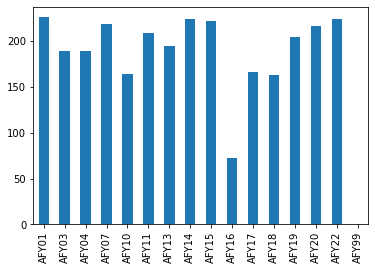

In [41]:
heatmap.count().plot(kind='bar')

## Comparison to ResistoMap (PCR based method)

In [205]:
#rm2c = ResistoMap - CARD
rm2c = pd.read_csv('primerCrossmatch.csv')
rm = rm2c[rm2c.Suggestion!="old remove"]
rm.head()

Unnamed: 0  Suggestion Gene target       AMG Class  Nr of Matches  \
0           0  old retain   16S old 1             NaN              0   
1           1  old retain   16S new 2             NaN             44   
2           2  old retain       aacC2  Aminoglycoside              4   
5           5  old retain   aacA/aphD  Aminoglycoside              1   
7           7  old retain  aac(6')-II  Aminoglycoside              1   

                                             match 1  \
0                                                NaN   
1  ARO:3003223|ID:2068|Name:Escherichia_coli_16S_...   
2   ARO:3002533|ID:478|Name:AAC_3_-IIa|NCBI:X13543.1   
5  ARO:3002597|ID:1814|Name:AAC_6__-Ie-APH_2___-I...   
7  ARO:3002594|ID:1657|Name:AAC_6__-IIa|NCBI:AY12...   

                                             match 2  \
0                                                NaN   
1  ARO:3003481|ID:2070|Name:Mycobacterium_tubercu...   
2  ARO:3002535|ID:1378|Name:AAC_3_-IIc|NCBI:X54723.1   
5                                                NaN   
7                                                NaN   

                                             match 3  \
0                                                NaN   
1  ARO:3003495|ID:2076|Name:Neisseria_gonorrhoeae...   
2  ARO:3004621|ID:3321|Name:AAC_3_-IIe|NCBI:EU022...   
5                                                NaN   
7                                                NaN   

                                             match 4  \
0                                                NaN   
1  ARO:3003515|ID:2078|Name:Mycobacteroides_chelo...   
2  ARO:3004623|ID:3322|Name:AAC_3_-IId|NCBI:EU022...   
5                                                NaN   
7                                                NaN   

                                             match 5  \
0                                                NaN   
1  ARO:3003493|ID:2116|Name:Pasteurella_multocida...   
2                                                NaN   
5                                                NaN   
7                                                NaN   

                                             match 6  \
0                                                NaN   
1  ARO:3003480|ID:2131|Name:Mycobacterium_tubercu...   
2                                                NaN   
5                                                NaN   
7                                                NaN   

                                             match 7  \
0                                                NaN   
1  ARO:3003402|ID:2069|Name:Escherichia_coli_16S_...   
2                                                NaN   
5                                                NaN   
7                                                NaN   

                                             match 8  \
0                                                NaN   
1  ARO:3003397|ID:2073|Name:Escherichia_coli_16S_...   
2                                                NaN   
5                                                NaN   
7                                                NaN   

                                             match 9  \
0                                                NaN   
1  ARO:3003512|ID:2074|Name:Salmonella_enterica_1...   
2                                                NaN   
5                                                NaN   
7                                                NaN   

                                            match 10  
0                                                NaN  
1  ARO:3003544|ID:2077|Name:Mycolicibacterium_sme...  
2                                                NaN  
5                                                NaN  
7                                                NaN

In [206]:
## splitting into: no match, exact match, multiple matches
rm0 = rm[rm["Nr of Matches"]==0]
rm1 = rm[rm["Nr of Matches"]==1]
rm2 = rm[rm["Nr of Matches"]>1]
rm1["CARD name"] = [m.split('|')[2].split(':')[-1] for m in rm1['match 1']]
rm1["ARO Term"] = [m.split('|')[0].split(':')[-1] for m in rm1['match 1']]
rm1[['Suggestion', 'AMG Class', 'Nr of Matches', 'match 1', 'Gene target', 'CARD name', "ARO Term"]].head()
#.to_csv("primerCrossmatchExact.csv", index=None)

/tmp/ipykernel_7874/4147389999.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rm1["CARD name"] = [m.split('|')[2].split(':')[-1] for m in rm1['match 1']]
/tmp/ipykernel_7874/4147389999.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rm1["ARO Term"] = [m.split('|')[0].split(':')[-1] for m in rm1['match 1']]


Suggestion       AMG Class  Nr of Matches  \
5   old retain  Aminoglycoside              1   
7   old retain  Aminoglycoside              1   
8   old retain             MDR              1   
10  old retain             MDR              1   
11  old retain             MDR              1   

                                              match 1 Gene target  \
5   ARO:3002597|ID:1814|Name:AAC_6__-Ie-APH_2___-I...   aacA/aphD   
7   ARO:3002594|ID:1657|Name:AAC_6__-IIa|NCBI:AY12...  aac(6')-II   
8         ARO:3000216|ID:1104|Name:acrB|NCBI:U00096.3        acrB   
10        ARO:3000502|ID:1437|Name:AcrF|NCBI:U00096.1        acrF   
11      ARO:3000774|ID:1313|Name:adeA|NCBI:AF370885.1        adeA   

                 CARD name ARO Term  
5   AAC_6__-Ie-APH_2___-Ia  3002597  
7              AAC_6__-IIa  3002594  
8                     acrB  3000216  
10                    AcrF  3000502  
11                    adeA  3000774

In [207]:
rm2

Unnamed: 0  Suggestion    Gene target        AMG Class  Nr of Matches  \
1             1  old retain      16S new 2              NaN             44   
2             2  old retain          aacC2   Aminoglycoside              4   
23           23  old retain           cfiA      Beta Lactam             17   
27           27  old retain       blaACC-1      Beta Lactam              8   
33           33  old retain  blaMOX/blaCMY      Beta Lactam             15   
..          ...         ...            ...              ...            ...   
562         562  new target          mcr-2            other              2   
563         563  new target        bla-ACT   Beta lactamase             60   
564         564  new target      aac(3)-Xa   Aminoglycoside              9   
595         595  new target          qnrS2  fluoroquinolone              2   
598         598  new target   qnrB46,47,48  fluoroquinolone             16   

                                               match 1  \
1    ARO:3003223|ID:2068|Name:Escherichia_coli_16S_...   
2     ARO:3002533|ID:478|Name:AAC_3_-IIa|NCBI:X13543.1   
23         ARO:3000578|ID:1381|Name:CcrA|NCBI:M63556.1   
27       ARO:3001818|ID:406|Name:ACC-4|NCBI:EF504260.2   
33          ARO:3002012|ID:20|Name:CMY-1|NCBI:X92508.1   
..                                                 ...   
562   ARO:3004502|ID:3130|Name:MCR-2.2|NCBI:MF176239.1   
563       ARO:3001855|ID:9|Name:ACT-35|NCBI:LC004922.1   
564      ARO:3002620|ID:69|Name:aadA23|NCBI:AJ809407.1   
595       ARO:3002795|ID:60|Name:QnrS6|NCBI:HQ631376.1   
598      ARO:3002762|ID:58|Name:QnrB47|NCBI:JX440358.1   

                                               match 2  \
1    ARO:3003481|ID:2070|Name:Mycobacterium_tubercu...   
2    ARO:3002535|ID:1378|Name:AAC_3_-IIc|NCBI:X54723.1   
23    ARO:3006906|ID:4445|Name:CfiA10|NCBI:NG_050388.1   
27      ARO:3001815|ID:1663|Name:ACC-1|NCBI:AJ133121.1   
33       ARO:3002020|ID:136|Name:CMY-9|NCBI:AB061794.1   
..                                                 ...   
562   ARO:3004110|ID:2778|Name:MCR-2.1|NCBI:LT598652.1   
563     ARO:3001850|ID:241|Name:ACT-30|NCBI:KM087833.1   
564     ARO:3002612|ID:149|Name:aadA12|NCBI:FJ381668.1   
595     ARO:3002791|ID:1832|Name:QnrS2|NCBI:DQ485530.1   
598      ARO:3002778|ID:71|Name:QnrB66|NCBI:KC580655.1   

                                               match 3  \
1    ARO:3003495|ID:2076|Name:Neisseria_gonorrhoeae...   
2    ARO:3004621|ID:3321|Name:AAC_3_-IIe|NCBI:EU022...   
23    ARO:3006907|ID:4446|Name:CfiA11|NCBI:NG_047630.1   
27      ARO:3001819|ID:1865|Name:ACC-5|NCBI:HE819401.1   
33       ARO:3002019|ID:269|Name:CMY-8|NCBI:AF167990.3   
..                                                 ...   
562                                                NaN   
563     ARO:3001845|ID:433|Name:ACT-25|NCBI:KJ207208.1   
564     ARO:3002617|ID:502|Name:aadA17|NCBI:FJ460181.2   
595                                                NaN   
598     ARO:3002751|ID:272|Name:QnrB36|NCBI:JN173058.1   

                                               match 4  \
1    ARO:3003515|ID:2078|Name:Mycobacteroides_chelo...   
2    ARO:3004623|ID:3322|Name:AAC_3_-IId|NCBI:EU022...   
23    ARO:3006908|ID:4447|Name:CfiA14|NCBI:NG_050390.1   
27    ARO:3006228|ID:4123|Name:ACC-1a|NCBI:NG_048589.1   
33       ARO:3002183|ID:688|Name:MOX-2|NCBI:AJ276453.1   
..                                                 ...   
562                                                NaN   
563      ARO:3001822|ID:526|Name:ACT-2|NCBI:AM076977.1   
564     ARO:3002618|ID:584|Name:aadA21|NCBI:AY171244.1   
595                                                NaN   
598     ARO:3002774|ID:382|Name:QnrB61|NCBI:AB734053.1   

                                               match 5  \
1    ARO:3003493|ID:2116|Name:Pasteurella_multocida...   
2                                                  NaN   
23    ARO:3006909|ID:4448|Name:CfiA17|NCBI:NG_054674.1   
27    ARO:3006229|ID:4124|Name:ACC-1b|NCBI:NG_04

### Loading RGI/CARD

In [208]:
heatmap = pd.DataFrame([extractHeatmapData(sid, col1='ARO Accession', col2='coverage', mapqThr=0, pCovThr = 50, mappedReadThr=0, log=False) for sid in sampleIDs]).transpose()

heatmap.columns = samples = [f'AFY{sid}' for sid in sampleIDs]

In [209]:
heatmap.head()

AFY01     AFY11     AFY13     AFY16
3002867  9.393939  6.060606  6.363636       NaN
3001711  0.727273       NaN       NaN       NaN
3002372  4.500000       NaN  4.166667       NaN
3002835  8.024691       NaN       NaN       NaN
3001800  8.695652  2.536232  6.702899  1.811594

In [210]:
rm2c = pd.read_csv('primerCrossmatch2all2.csv')
#rm = rm2c[rm2c.Suggestion!="old remove"]
aros = []
a = rm2c.iloc[:, 5:]
dimx, dimy = a.shape
dim = dimx * dimy
a = [int(el) for el in np.array(a).reshape(1, dimx * dimy)[0] if not el is np.nan]


ValueError: cannot convert float NaN to integer

In [211]:
rm.loc[2]
#[rm.]

Unnamed: 0                                                       2
Suggestion                                              old retain
Gene target                                                  aacC2
AMG Class                                           Aminoglycoside
Nr of Matches                                                    4
match 1           ARO:3002533|ID:478|Name:AAC_3_-IIa|NCBI:X13543.1
match 2          ARO:3002535|ID:1378|Name:AAC_3_-IIc|NCBI:X54723.1
match 3          ARO:3004621|ID:3321|Name:AAC_3_-IIe|NCBI:EU022...
match 4          ARO:3004623|ID:3322|Name:AAC_3_-IId|NCBI:EU022...
match 5                                                        NaN
match 6                                                        NaN
match 7                                                        NaN
match 8                                                        NaN
match 9                                                        NaN
match 10                                                      

In [212]:
relab = pd.read_csv('../Resistome/Relative abundances.csv')
relab.head()

group           gene  assay        1A        2A        3A        4A
0  Taxanomic     Firmicutes  AY477  0.258219  0.954842  0.272312  0.388683
1  Taxanomic  Bacteroidetes  AY474  0.067921  0.194342  0.137103  0.153184
2  Taxanomic   A. baumannii  AY473  0.000021       NaN       NaN       NaN
3  Taxanomic  P. aeruginosa  AY479  0.000011       NaN       NaN       NaN
4  Taxanomic  Campylobacter  AY475       NaN       NaN       NaN       NaN

In [108]:
!pwd

/home/ahenschel/AMG_Metagenomes_AhmedY/ResistomeComparison


In [213]:
res = pd.read_csv('../Resistome/Numbers of detected genes.csv', index_col='Description')

In [214]:
res1 = res.iloc[:,2:]
res1 = res1.iloc[:,res1.sum().argsort()[::-1]]
res1

MGE  Aminoglycoside  MDR  MLSB  Tetracycline  Beta Lactam  \
Description                                                              
AFY1          28              20   20    15            15           17   
AFY11         25              21   20    16            13           14   
AFY13         27              19   21    14            16           12   
AFY16         24              20   14    12            13           12   

             Phenicol  Other  Trimethoprim  Quinolone  Integrons  Taxanomic  \
Description                                                                   
AFY1                6      5             7          7          2          4   
AFY11               8      7             7          7          2          2   
AFY13               9      8             7          5          3          2   
AFY16               5      7             5          4          4          2   

             Sulfonamide  Vancomycin  
Description                           
AFY1                   2           1  
AFY11                  3           2  
AFY13                  2           0  
AFY16                  2           0

In [215]:
## file prepared by linkResistome2CardDrugClasses.py
res2 = pd.read_csv("ngs2resi.csv", index_col=0)
res2 = res2.iloc[:,res2.sum().argsort()[::-1]]
res2

res2a = res2.loc[[1, 11, 13, 16]]
#res2a.columns = "Vancomycin Sulfonamide Phenical Beta-Lactam Quinolone Tetracycline Others Aminoglycoside MLSB".split()
renameDict = {'sulfonamide antibiotic': 'Sulfonamide',
 'aminoglycoside antibiotic': 'Aminoglycoside',
 'phenicol antibiotic': 'Phenicol ',
 'glycopeptide antibiotic': 'Vancomycin',
 'fluoroquinolone antibiotic': 'Quinolone',
 'beta-lactam antibiotic': 'Beta lactam',
 'tetracycline antibiotic': 'Tetracycline',
 'diaminopyrimidine (trimethoprim)': 'Trimethoprim',
 'mlsb': 'MLSB'}
res2a = res2a.rename(columns=renameDict)
colordict={'Sulfonamide': 'tab:green', 'Aminoglycoside': 'tab:orange', 'Phenicol ': 'tab:pink', 'Vancomycin': 'tab:red', 'Quinolone': 'tab:cyan', 'Beta lactam': 'tab:brown', 'Tetracycline': 'tab:red',  'Trimethoprim': 'tab:olive', 'MLSB': 'tab:purple', 'Others': 'tab:gray', 'MDR': 'tab:green' }
res2a

Aminoglycoside          MLSB       Others  Tetracycline          MDR  \
1     11283.517623  13391.837251  5550.292268   6539.032044  2125.591858   
11     9411.216155   9290.165903  5679.243007   3496.984844  2037.811081   
13    12947.792272  10427.696515  5861.662505   2637.859570  2294.538132   
16     3204.439688   2385.299604  2186.426233    515.614416   806.322218   

    Beta lactam    Quinolone  Sulfonamide   Phenicol   Trimethoprim  \
1   1374.768329  1550.240761   439.015464  425.840123    207.972312   
11   724.362293  1239.445344   252.419907  402.549356     96.248739   
13  1806.972682  1402.847661  1113.174260  710.728236    223.322245   
16   175.733407   438.297462    93.955113  107.851145     13.250863   

    Vancomycin  
1    79.646269  
11   71.657777  
13   50.168868  
16   13.768060

In [216]:
res3 = pd.read_csv("ngs2resiQC1.csv", index_col=0)
res3

diaminopyrimidine (trimethoprim)  beta-lactam antibiotic  mlsb  Others  \
1                                7.0                     105    72     116   
3                                1.0                      27    62     104   
4                                7.0                     115    68     107   
7                                4.0                      58    76     114   
10                               6.0                     145    65     102   
11                               5.0                      80    71     114   
13                               7.0                     195    71     113   
14                               7.0                     135    72     118   
15                              12.0                     206    75     114   
16                               1.0                      20    48      82   
17                               5.0                      95    57     103   
18                               5.0                     141    66     102   
19                               7.0                     164    68     109   
20                               9.0                     198    64     108   
22                               8.0                     187    70     114   
99                               NaN                       4     1       5   

    fluoroquinolone antibiotic  aminoglycoside antibiotic  MDR  \
1                           53                         98   84   
3                           35                         83   78   
4                           42                         93   76   
7                           40                         90   74   
10                          43                         91   67   
11                          49                         92   73   
13                          46                        101   76   
14                          49                         97   76   
15                          46                        107   83   
16                          26                         66   47   
17                          41                         84   78   
18                          40                         97   62   
19                          46                         95   80   
20                          49                        100   93   
22                          50                        107   91   
99                           1                          4    7   

    phenicol antibiotic  tetracycline antibiotic  sulfonamide antibiotic  \
1                    15                       38                       5   
3                     9                       30                       3   
4                    15                       29                       6   
7                    17                       33                       5   
10                   17                       31                       4   
11                   15                       36                       5   
13                   18                       29                       5   
14                   18                       37                       5   
15                   18                       38                       5   
16                    8                       22                       5   
17                   13                       26                       5   
18                   14                       30                       5   
19                   17                       34                       5   
20                   16                       32                       6   
22                   17                       38                       5   
99                    1                        1                       1   

    glycopeptide antibiotic  
1                         4  
3                         2  
4                         2  
7                         3  
10                        2  
11                        3  
13                        3  
14                   

In [113]:
res3 = res3.iloc[:,res3.sum().argsort()[::-1]]
res3a = res3.loc[[1, 11, 13, 16]]
res3a = res3a.rename(columns=renameDict)
res3a

Beta lactam  Others  Aminoglycoside  MDR  MLSB  Quinolone  Tetracycline  \
1           105     116              98   84    72         53            38   
11           80     114              92   73    71         49            36   
13          195     113             101   76    71         46            29   
16           20      82              66   47    48         26            22   

    Phenicol   Trimethoprim  Sulfonamide  Vancomycin  
1          15           7.0            5           4  
11         15           5.0            5           3  
13         18           7.0            5           3  
16          8           1.0            5           3

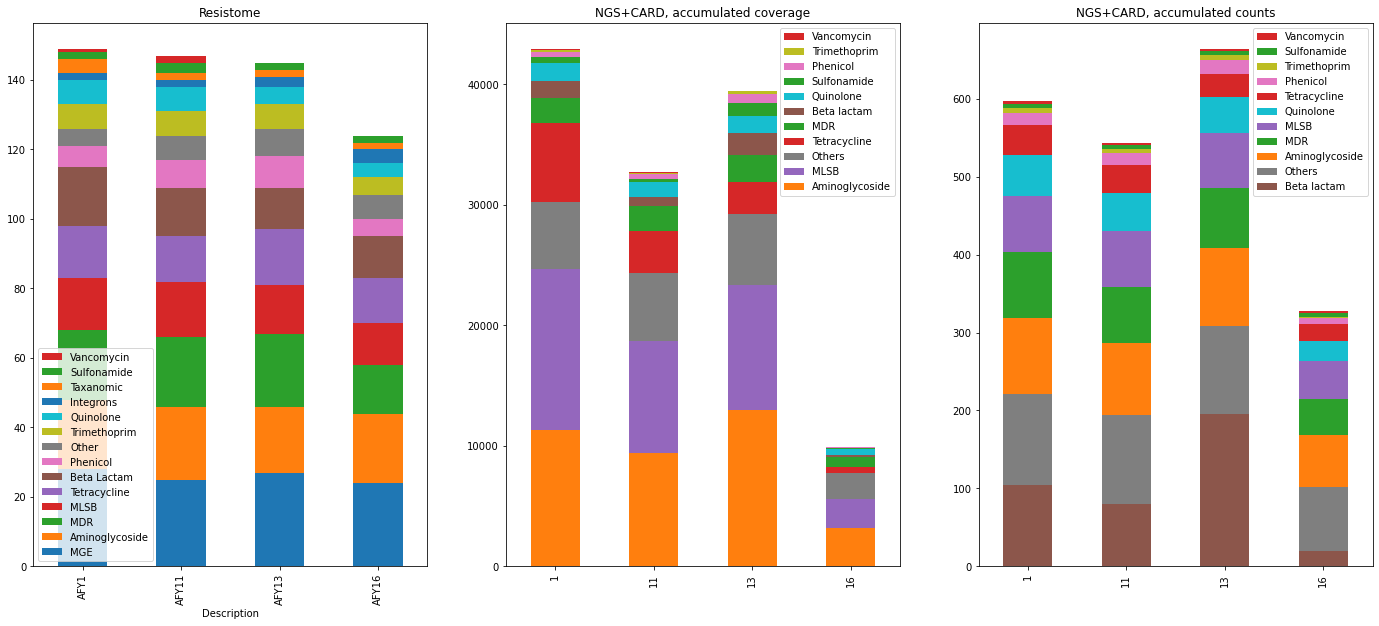

In [114]:
plt.rcParams['figure.figsize'] = [24, 10]
fig, axes = plt.subplots(ncols=3)
_=res1.plot(ax=axes[0], kind='bar', stacked=True, legend='reverse', title="Resistome")
_=res2a.plot(ax=axes[1], kind='bar', stacked=True, legend='reverse', color=[colordict[col] for col in res2a.columns], title="NGS+CARD, accumulated coverage")
_=res3a.plot(ax=axes[2], kind='bar', stacked=True, legend='reverse', color=[colordict[col] for col in res3a.columns], title="NGS+CARD, accumulated counts")


In [23]:
res2.iloc

In [56]:
tbl = pie(geneQC, 'Drug Class', width=2400)

NameError: name 'pie' is not defined

In [115]:
res = pd.read_csv('../Resistome/Relative abundances.csv')
res = res[res.group!='Taxanomic']
res = res[res.group!='16S rRNA']
res

group     gene  assay        1A        2A        3A        4A
8     Integrons  intI1_2  AY289  0.036398  0.061143  0.154785  0.047257
9     Integrons  intI1_1  AY293       NaN       NaN  0.166470  0.084299
10    Integrons  intI2_2  AY294  0.000589  0.001148  0.000671  0.000124
11    Integrons    intl3  AY500       NaN       NaN       NaN  0.000822
12          MGE   IS26_1  AY512  0.038741  0.062428  0.305307  0.073387
..          ...      ...    ...       ...       ...       ...       ...
378  Vancomycin  vanSC_2  AY380       NaN       NaN       NaN       NaN
379  Vancomycin     vanA  AY595       NaN       NaN       NaN       NaN
380  Vancomycin     vanG  AY597       NaN       NaN       NaN       NaN
381  Vancomycin    vanXA  AY598       NaN       NaN       NaN       NaN
382  Vancomycin    vanSB  AY599       NaN       NaN       NaN       NaN

[375 rows x 7 columns]

In [116]:
res.iloc[:,-4:].sum(axis=0)

1A    0.443264
2A    0.961562
3A    2.021415
4A    0.738633
dtype: float64

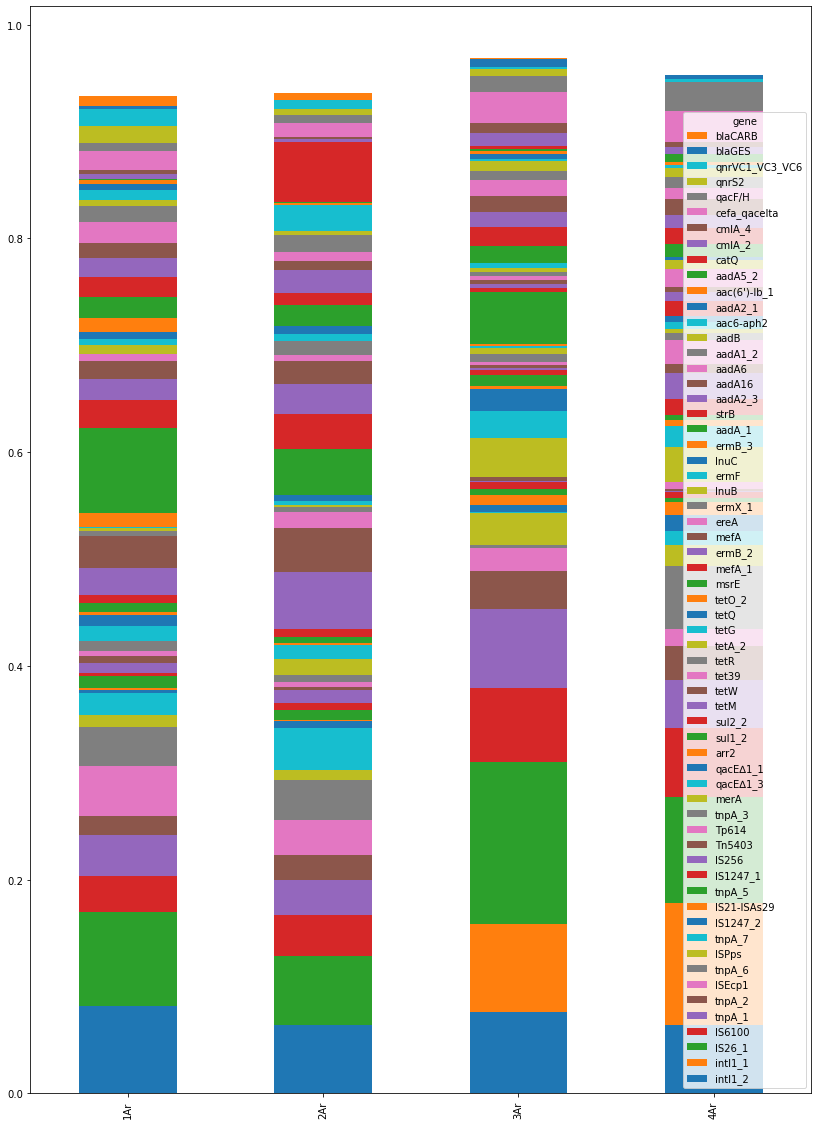

In [117]:
for k,v in res.sum().items():
    if len(k)==2:
        res[f'{k}r'] = res[k]/v 

res = res.set_index('gene').iloc[:,-4:]
res['total'] = res.sum(axis=1)
res = res[res.total>0.01]
plt.rcParams['figure.figsize'] = [14, 20]
_=res.iloc[:,:4].transpose().plot(kind='bar', stacked=True, legend="reverse")

#res.sort_values(by='total', ascending=False).tail(100)
#res.transpose().plot(kind='bar', stacked=True)

## Gene based comparison
Gene names are a mess. It's hard to make direct matches.
Resistome's PCR assays check for 384 amplification results in their respective assays. From those, 198 are present in at least one sample.

In contrast 4891 genes are in the CARD database (v3.2.2).
Depending on thresholds for detection, eg. requiring at least 100 reads: 321 genes are reported in total. If 50% of the gene is required to be covered, but no threshold for nr. of genes: 818 genes

The immediate overlap of genes (exact gene name match) present in both is 28.
Below are some tools intended to help to extend the overlap, by assisting gene name matches.

Apart from the issue with the gene names, the second challenge is to compare relative abundances to the gene quantities present in the metagenomes. For the latter, options are: raw read count, coverage, percentage of reads wrt to all reads.
The latter was determined with 
`samtools view -c AFY01.sorted.length_100.bam`
alternatively mapped reads against the reference of resistance genes:

`(samtools) ahenschel@Hydrogen:/mnt/Drive1/ahenschel/SambaShare/AMG_Metagenomes_AhmedY/ResistomeComparison$ samtools view -c AFY01.sorted.length_100.bam
85893508
(samtools) ahenschel@Hydrogen:/mnt/Drive1/ahenschel/SambaShare/AMG_Metagenomes_AhmedY/ResistomeComparison$ samtools view -c AFY11.sorted.length_100.bam
78593058
(samtools) ahenschel@Hydrogen:/mnt/Drive1/ahenschel/SambaShare/AMG_Metagenomes_AhmedY/ResistomeComparison$ samtools view -c AFY13.sorted.length_100.bam
82806922
(samtools) ahenschel@Hydrogen:/mnt/Drive1/ahenschel/SambaShare/AMG_Metagenomes_AhmedY/ResistomeComparison$ samtools view -c AFY16.sorted.length_100.bam
79518594`


### Reading ResistoMap
Normalization seems necessary, columns do not add up to 1

In [21]:
res1 = pd.read_csv('../Resistome/Relative abundances48.csv')
res1 = res1.set_index('gene').iloc[:,2:]
res1.head()

1A        2A        3A        4A        5A        6A        7A  \
gene                                                                           
aadA7   0.164178  0.338368  0.165702  0.149339  0.147624  0.069028  0.362654   
aadA16  0.016326  0.041235  0.015953  0.029360  0.015023  0.017701  0.036482   
strB    0.009464  0.030325  0.005550  0.029908  0.015128  0.034355  0.016592   
aadB    0.012287  0.025678  0.011177  0.011979  0.020333  0.017990  0.015990   
aadA6   0.007139  0.019823  0.004529  0.014748  0.007460  0.013888  0.018928   

              8A        9A       10A       11A       12A       13A       14A  \
gene                                                                           
aadA7   0.306367  0.167241  0.062645  0.178831  0.292532  0.114493  0.121863   
aadA16  0.049606  0.029839  0.015916  0.030186  0.038473  0.022614  0.036567   
strB    0.043990  0.047476  0.025559  0.017417  0.108819  0.052073  0.051237   
aadB    0.028690  0.019460  0.016251  0.037077  0.017824  0.020146  0.021197   
aadA6   0.029770  0.017783  0.012898  0.015410  0.017907  0.017660  0.025383   

             15A       16A       17A       18A       19A       20A       21A  \
gene                                                                           
aadA7   0.209739  0.145256  0.057912  0.129109  0.139339  0.332171  0.256435   
aadA16  0.020146  0.020333  0.015023  0.016785  0.030891  0.043990  0.041810   
strB    0.012402  0.015093  0.033262  0.007256  0.031395  0.025149  0.028229   
aadB    0.031980  0.012575  0.014511  0.010574  0.014646  0.021793  0.013230   
aadA6   0.009184  0.009912  0.013792  0.005361  0.017178  0.029090  0.020428   

             22A       23A       24A       25A       26A       27A       28A  \
gene                                                                           
aadA7   0.138057  0.439317  0.154963  0.227405  0.362654  0.470304  0.157490   
aadA16  0.021793  0.040014  0.024632  0.034039  0.024462  0.034594  0.019915   
strB    0.018199  0.022561  0.040479  0.022097  0.013200  0.014180  0.009420   
aadB    0.010796  0.021793  0.022148  0.036482  0.023793  0.020054  0.023519   
aadA6   0.012750  0.021944  0.015198  0.018073  0.008549  0.010846  0.008296   

             29A       30A       31A       32A       33A       34A       35A  \
gene                                                                           
aadA7   0.145256  0.122428  0.466516  0.302848  0.205898  0.171943  0.130007   
aadA16  0.024293  0.025091  0.072964  0.040573  0.033882  0.023142  0.019104   
strB    0.016746  0.037508  0.056328  0.020333  0.022148  0.046284  0.016980   
aadB    0.032054  0.018115  0.025266  0.039738  0.037508  0.026954  0.015023   
aadA6   0.018115  0.014954  0.044502  0.021246  0.018368  0.021295  0.010501   

             36A       37A       38A       39A       40A       41A       42A  \
gene                                                                           
aadA7   0.133972  0.116629  0.202127  0.282567  0.295248  0.147966  0.307076   
aadA16  0.031980  0.016631  0.034996  0.049037  0.039282  0.024014  0.030466   
strB    0.022614  0.014445  0.035731  0.028164  0.016902  0.021394  0.021246   
aadB    0.029977  0.023519  0.040200  0.046930  0.034118  0.027905  0.015953   
aadA6   0.025149  0.009291  0.022354  0.029977  0.017059  0.018283  0.020146   

             43A       44A       45A       46A       47A       48A  
gene                                                                
aadA7   0.058315  0.186425  0.199805  0.115824  0.189027  0.111105  
aadA16  0.016902  0.025383  0.029701  0.027970  0.025442  0.018972  
strB    0.026400  0.017138  0.028164  0.025266  0.022561  0.016824  
aadB    0.015916  0.013571  0.035158  0.025500  0.022199  0.020287  
aadA6   0.015990  0.012546  0.024125  0.021692  0.018199  0.012546

In [22]:
res0 = pd.read_csv('../Resistome/Relative abundances.csv')
res0 = res0.set_index('gene').iloc[:,2:]

In [ ]:
res01 = pd.merge(res0, res1, left_index=True, right_index=True)

res1 = res.set_index('gene').iloc[:,2:]

<AxesSubplot:ylabel='gene'>

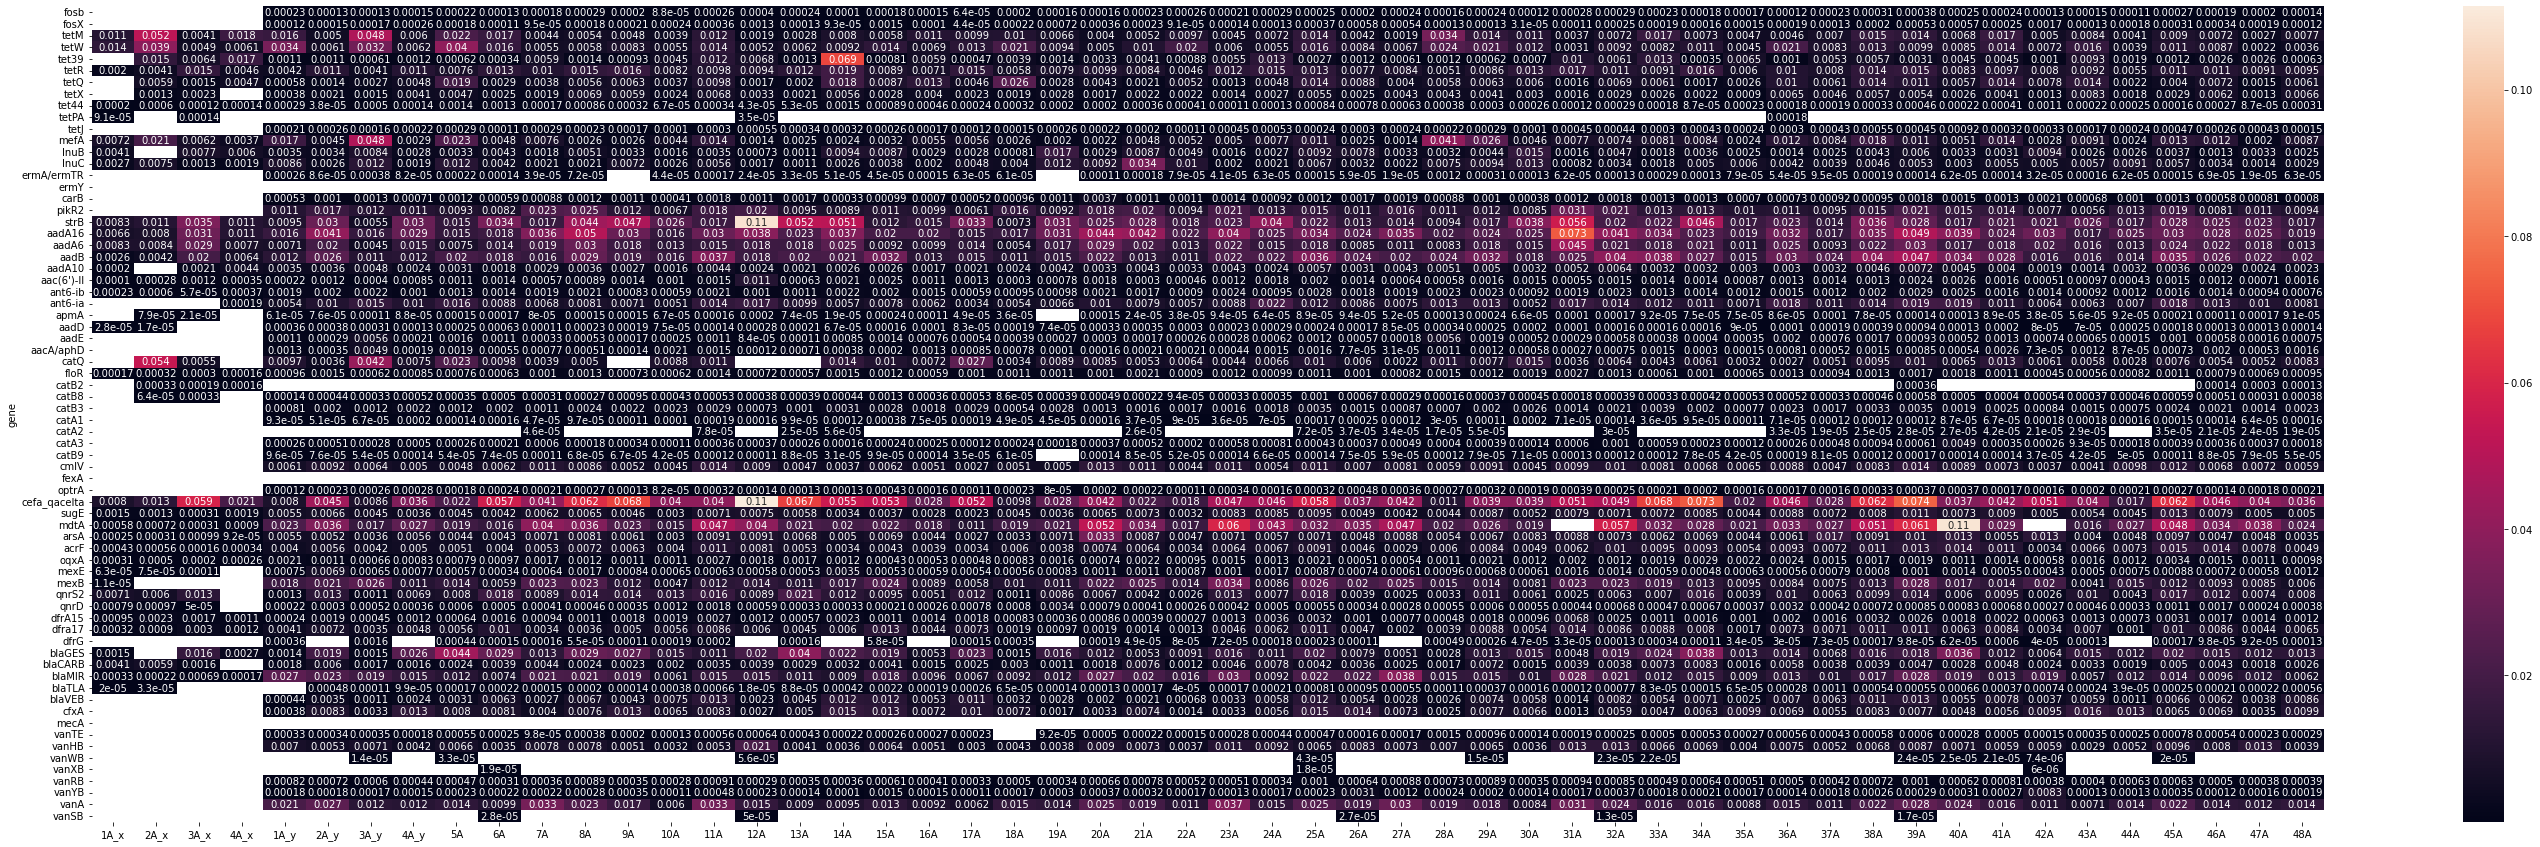

In [30]:
fig, ax = plt.subplots(1, figsize=(50, 15))
res01 = res01.iloc[:-1] ## excluding 16S (1 all over)
res01 = res01[res01.index!='aadA7']
sns.heatmap(res01, annot=True, ax=ax)

In [31]:
fig.savefig('48new_vs_4old_samples_NOaadA7.pdf')

<AxesSubplot:ylabel='gene'>

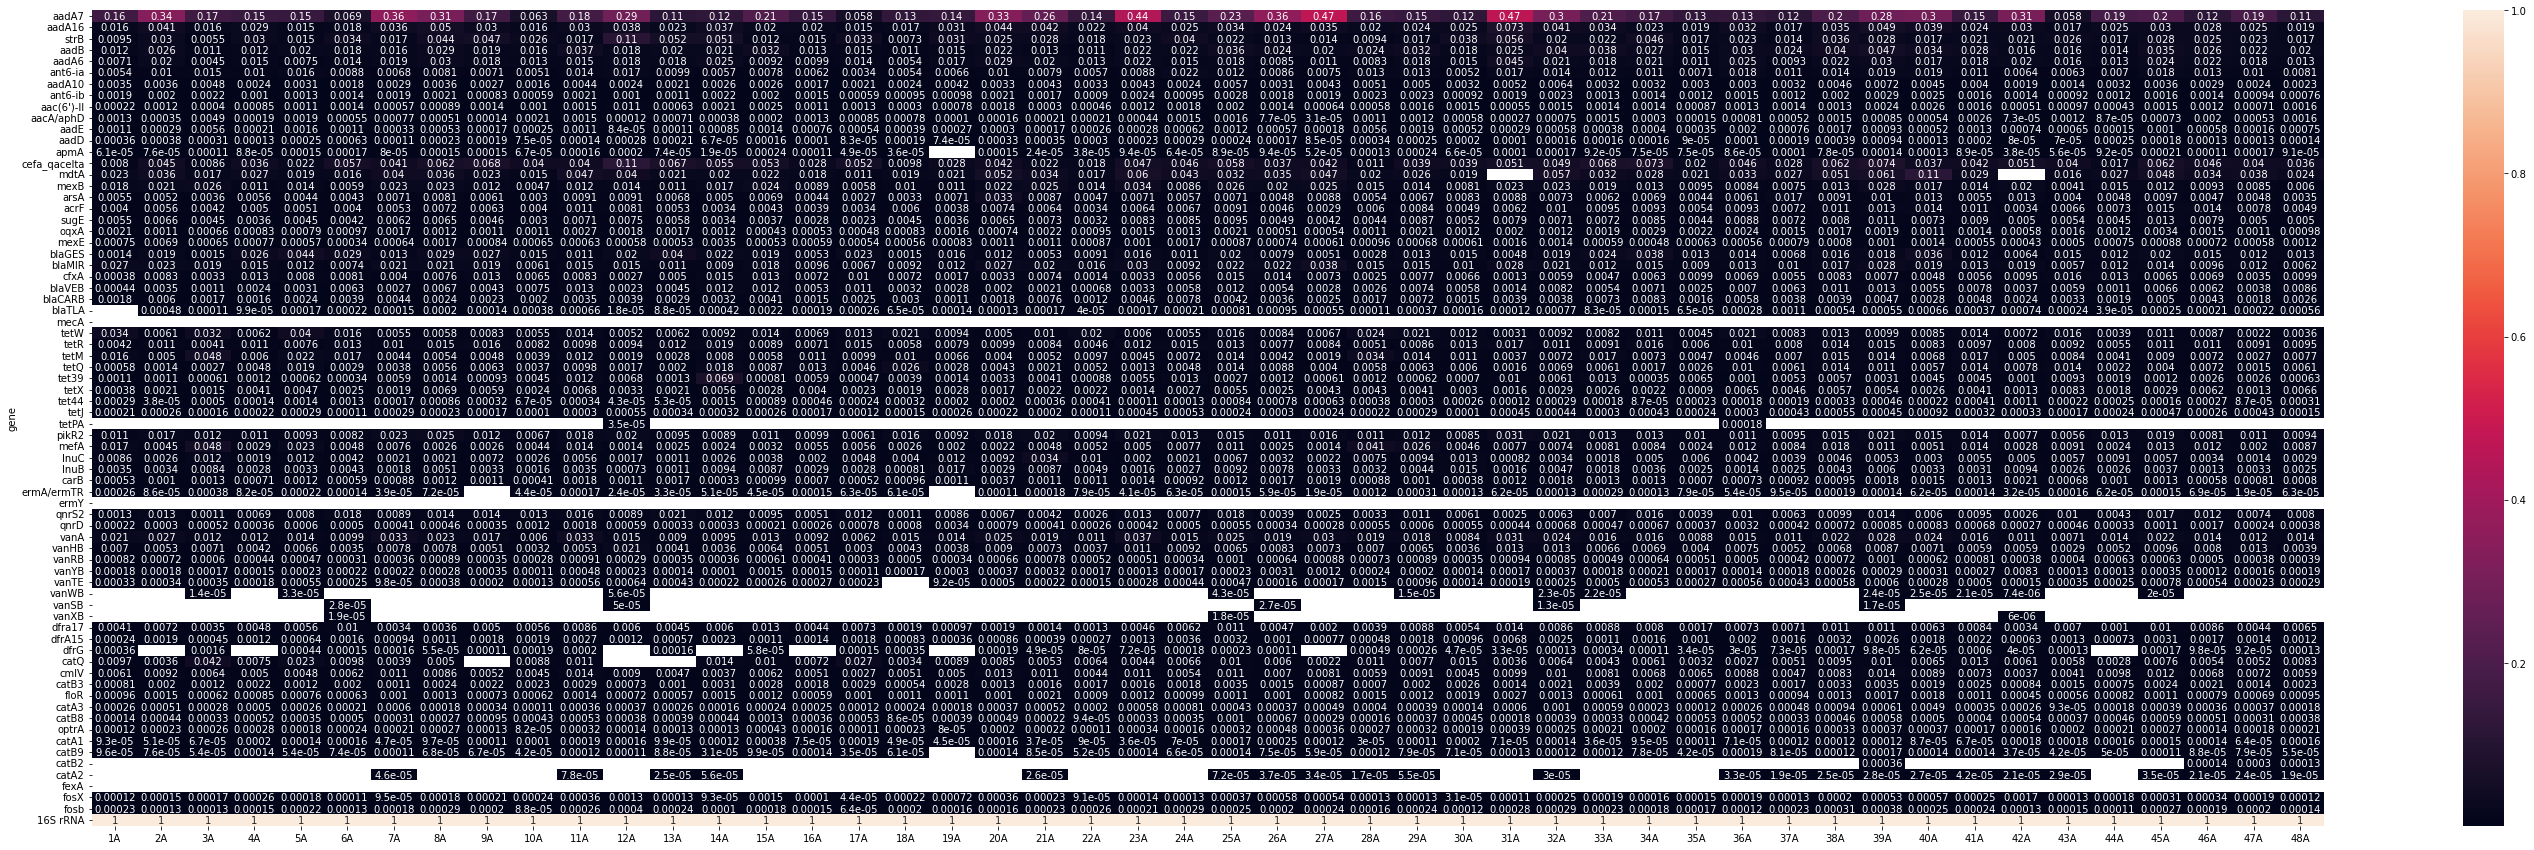

In [12]:
allResistomap = set(res.gene)
len(allResistomap)
res.head(3)



In [13]:
fig.savefig('48samples.pdf')

In [218]:
rm1.head(3)

Unnamed: 0  Suggestion Gene target       AMG Class  Nr of Matches  \
5           5  old retain   aacA/aphD  Aminoglycoside              1   
7           7  old retain  aac(6')-II  Aminoglycoside              1   
8           8  old retain        acrB             MDR              1   

                                             match 1 match 2 match 3 match 4  \
5  ARO:3002597|ID:1814|Name:AAC_6__-Ie-APH_2___-I...     NaN     NaN     NaN   
7  ARO:3002594|ID:1657|Name:AAC_6__-IIa|NCBI:AY12...     NaN     NaN     NaN   
8        ARO:3000216|ID:1104|Name:acrB|NCBI:U00096.3     NaN     NaN     NaN   

  match 5 match 6 match 7 match 8 match 9 match 10               CARD name  \
5     NaN     NaN     NaN     NaN     NaN      NaN  AAC_6__-Ie-APH_2___-Ia   
7     NaN     NaN     NaN     NaN     NaN      NaN             AAC_6__-IIa   
8     NaN     NaN     NaN     NaN     NaN      NaN                    acrB   

  ARO Term  
5  3002597  
7  3002594  
8  3000216

In [219]:
## resistomap genes without hit
for gene in sorted(allResistomap - set(resn.index), key=lambda x:x.lower()):
    print(gene)

NameError: name 'resn' is not defined

In [220]:
res

group           gene  assay        1A        2A        3A        4A
0     Taxanomic     Firmicutes  AY477  0.258219  0.954842  0.272312  0.388683
1     Taxanomic  Bacteroidetes  AY474  0.067921  0.194342  0.137103  0.153184
2     Taxanomic   A. baumannii  AY473  0.000021       NaN       NaN       NaN
3     Taxanomic  P. aeruginosa  AY479  0.000011       NaN       NaN       NaN
4     Taxanomic  Campylobacter  AY475       NaN       NaN       NaN       NaN
..          ...            ...    ...       ...       ...       ...       ...
379  Vancomycin           vanA  AY595       NaN       NaN       NaN       NaN
380  Vancomycin           vanG  AY597       NaN       NaN       NaN       NaN
381  Vancomycin          vanXA  AY598       NaN       NaN       NaN       NaN
382  Vancomycin          vanSB  AY599       NaN       NaN       NaN       NaN
383    16S rRNA       16S rRNA    AY1  1.000000  1.000000  1.000000  1.000000

[384 rows x 7 columns]

### Reading NGS data
This is subjected to filtering
see parameters for extractHeatmapData

In [221]:
totalreads = [85893508, 78593058, 82806922, 79518594] # should divide reads of a gene with this (?), similar though
sampleIDs = '01 11 13 16'.split() ## samples with Resistomap data
#ngs = pd.DataFrame([extractHeatmapData(sid, mapqThr=0, pCovThr = 10, mappedReadThr=0, log=False) for sid in sampleIDs]).transpose() ## this reports "Completely mapped reads"
#extractHeatmapData('01', col1='ARO Accession', col2='coverage', mapqThr=0, pCovThr = 95, mappedReadThr=0, log=False)
ngs = pd.DataFrame([extractHeatmapData(sid, col1='ARO Accession', col2='coverage', mapqThr=0, pCovThr = 95, mappedReadThr=0, log=False) for sid in sampleIDs]).transpose() ## this reports "Completely mapped reads"
ngs50 = pd.DataFrame([extractHeatmapData(sid, col1='ARO Accession', col2='coverage', mapqThr=0, pCovThr = 50, mappedReadThr=0, log=False) for sid in sampleIDs]).transpose()
ngs25 = pd.DataFrame([extractHeatmapData(sid, col1='ARO Accession', col2='coverage', mapqThr=0, pCovThr = 25, mappedReadThr=0, log=False) for sid in sampleIDs]).transpose()
ngs.columns = ngs50.columns = ngs25.columns = samples = [f'AFY{sid}' for sid in sampleIDs]
ngs25.head(3)

AFY01     AFY11     AFY13     AFY16
3002867  9.393939  6.060606  6.363636  0.909091
3002244  0.668896       NaN  0.334448       NaN
3001711  0.727273       NaN  0.727273       NaN

NameError: name 'res01' is not defined

In [223]:
## pedestrian joining
data = []
samplesRM = "AFY01r	AFY11r	AFY13r	AFY16r".split()
samplesCARD = list(ngs.columns.values)
samplesCARD2 = "AFY01p	AFY11p	AFY13p	AFY16p".split()
samplesCARD3 = "AFY01q	AFY11q	AFY13q	AFY16q".split()

header = ['ARO', 'group', 'gene', 'assay'] + samplesRM + samplesCARD + samplesCARD2 + samplesCARD3
for i,row in res.iterrows():
    gene = row["gene"]
    match = rm1[rm1["Gene target"]==gene]

    if match.shape[0]==1: ## unique match (should be, it is rm1)
        card = match.iloc[0]['ARO Term'] #.iloc[0,-1]
        card = int(card)
        rec = [card]+ list(row) 
        for ngsDF in [ngs, ngs50, ngs25]:            
            if card in ngsDF.index:
                rec += list(ngsDF.loc[card])
            else:
                #print(f"Warning: {card} not found: (match {match.iloc[0]})")
                rec += [None]*4
        data.append(rec)
        
comp = pd.DataFrame(data, columns=header) #.fillna(0)
comp.set_index('gene', inplace=True)

In [224]:
comp.shape

(93, 19)

Text(0.5, 1.0, 'NGS/CARD (partial - 250%)')

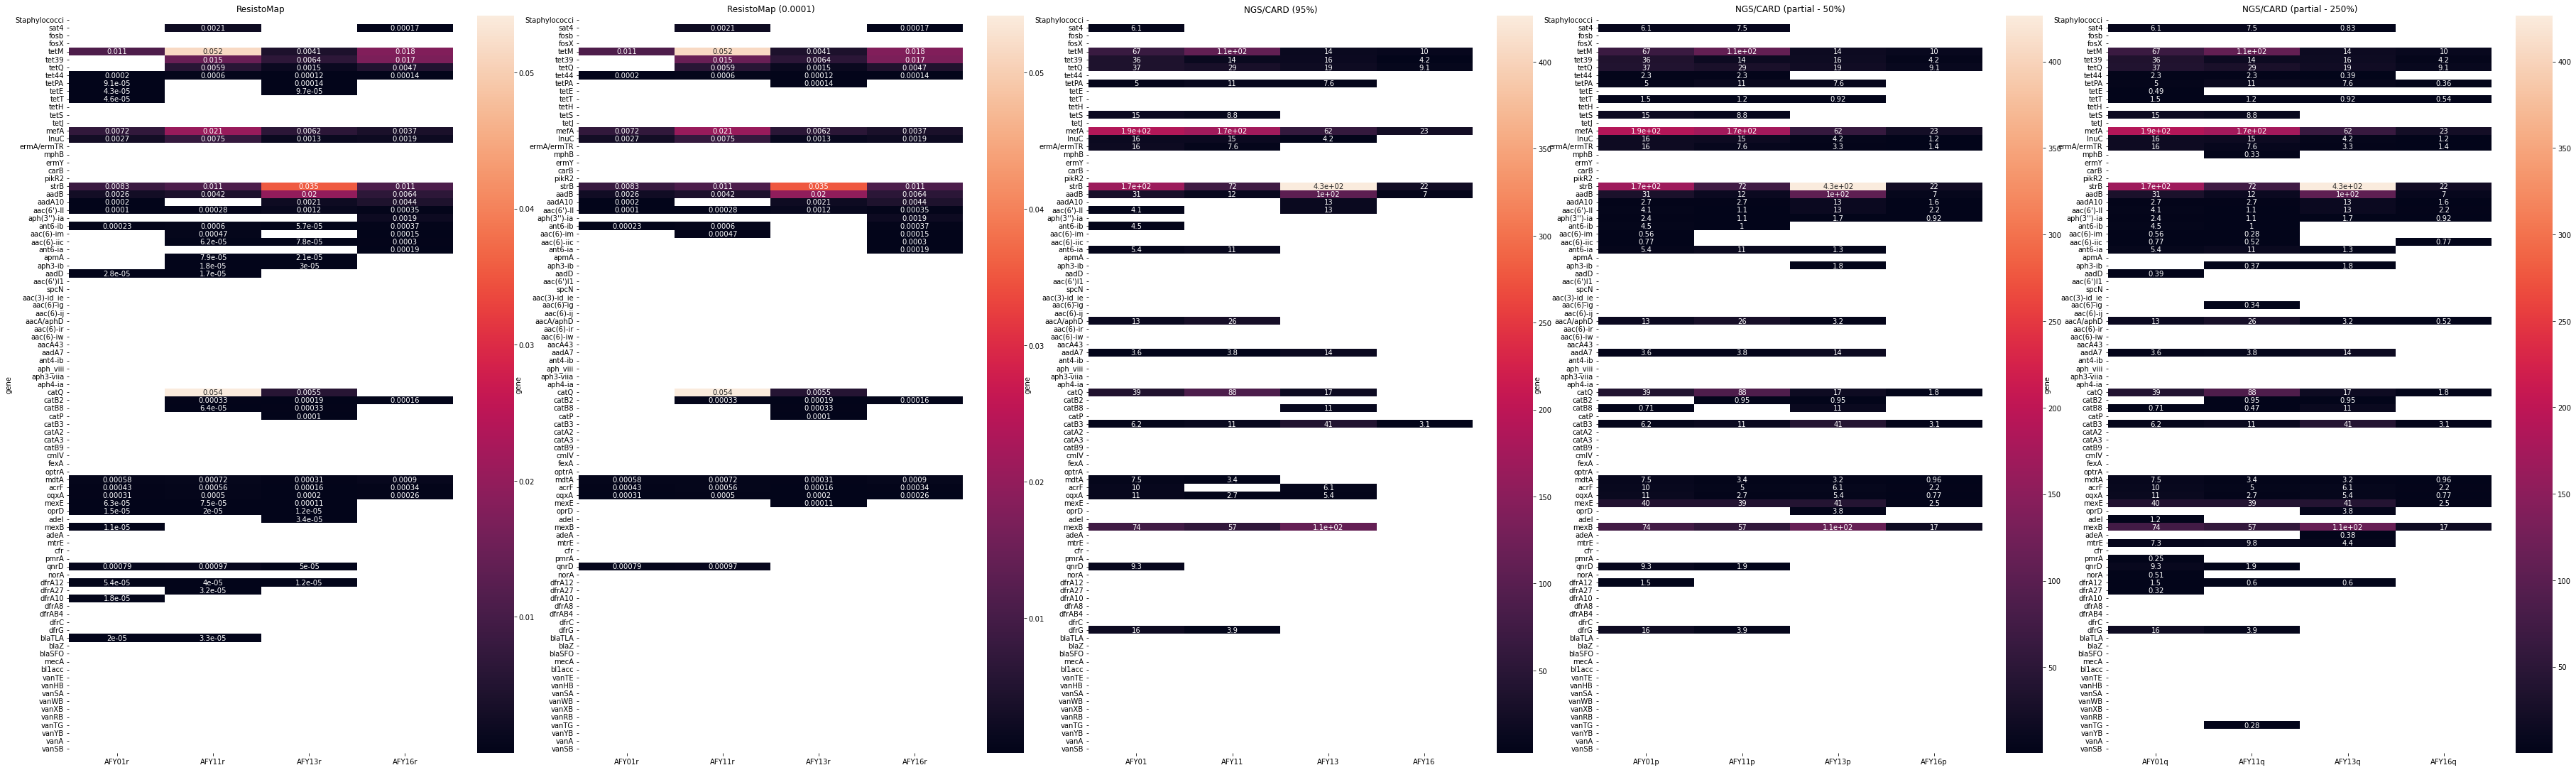

In [225]:
#comp = comp.dropna(how='all', subset=samplesRM+samplesCARD+samplesCARD2).sort_index()
compRM = comp[samplesRM]
compCARD = comp[samplesCARD]
compCARD2 = comp[samplesCARD2]
compCARD3 = comp[samplesCARD3]

fig, axs = plt.subplots(1,5, figsize=(50, 15))
fig.tight_layout()
sns.heatmap(compRM, annot=True, ax=axs[0])
sns.heatmap(compRM.mask(compRM<0.0001), annot=True, ax=axs[1])
sns.heatmap(compCARD, annot=True, ax=axs[2])
sns.heatmap(compCARD2, annot=True, ax=axs[3])
sns.heatmap(compCARD3, annot=True, ax=axs[4])
axs[0].set_title("ResistoMap")
axs[1].set_title("ResistoMap (0.0001)")
axs[2].set_title("NGS/CARD (95%)")
axs[3].set_title("NGS/CARD (partial - 50%)")
axs[4].set_title("NGS/CARD (partial - 250%)")

#axs[0].matshow(compRM, cmap=cmap)
#axs[1].matshow(compCARD, cmap=cmap)
#hm = sns.clustermap(comp.iloc[:,2:], figsize=(8,8), dendrogram_ratio=(0.3,.05), cmap=cmap)

In [226]:
compRM.shape
compCARD

AFY01       AFY11     AFY13      AFY16
gene                                                     
Staphylococci        NaN         NaN       NaN        NaN
sat4            6.077348         NaN       NaN        NaN
fosb                 NaN         NaN       NaN        NaN
fosX                 NaN         NaN       NaN        NaN
tetM           66.640625  110.078125  14.21875  10.078125
...                  ...         ...       ...        ...
vanRB                NaN         NaN       NaN        NaN
vanTG                NaN         NaN       NaN        NaN
vanYB                NaN         NaN       NaN        NaN
vanA                 NaN         NaN       NaN        NaN
vanSB                NaN         NaN       NaN        NaN

[93 rows x 4 columns]

In [227]:
a0 = compRM.mask(compRM<0.0001).fillna(0).to_numpy().reshape(93*4)
a1 = compRM.fillna(0).to_numpy().reshape(93*4)
a2 = compCARD.fillna(0).to_numpy().reshape(93*4)
a3 = compCARD2.fillna(0).to_numpy().reshape(93*4)
a4 = compCARD3.fillna(0).to_numpy().reshape(93*4)
corrDF = pd.DataFrame(zip(a1,a0, a2,a3,a4))
corrDF.columns = ['ResistoMap', 'ResistoMap1', 'CARD95', 'CARD50', 'CARD25']
corrDF.corr()

ResistoMap  ResistoMap1    CARD95    CARD50    CARD25
ResistoMap     1.000000     0.999996  0.635938  0.630736  0.630428
ResistoMap1    0.999996     1.000000  0.635975  0.630682  0.630374
CARD95         0.635938     0.635975  1.000000  0.992359  0.992155
CARD50         0.630736     0.630682  0.992359  1.000000  0.999749
CARD25         0.630428     0.630374  0.992155  0.999749  1.000000

In [232]:
a3.shape

(372,)

In [53]:
a1 = compRM.head().fillna(0).to_numpy().reshape(20)
a2 = compCARD.head().fillna(0).to_numpy().reshape(20)
corrDF = pd.DataFrame(zip(a1,a2))
corrDF.corr?

In [45]:
fig.savefig('1-1_GD.svg')

## Matching 1-many (homolog)
If Resistomap primer pairs match multiple genes in CARD, but these genes have similar names (alternatively: check similar ARO characteristics), we compare the PCR signal between ResistoMap and the accumulated coverage of the group of CARD genes.


In [233]:
ngs = pd.DataFrame([extractHeatmapData(sid, col1='ARO Accession', col2='coverage', mapqThr=0, pCovThr = 95, mappedReadThr=0, log=False) for sid in sampleIDs]).transpose() ## this reports "Completely mapped reads"
ngs.columns = [f'AFY{sid}' for sid in sampleIDs]
ngs

AFY01       AFY11       AFY13      AFY16
3002867    9.393939    6.060606    6.363636        NaN
3002372    4.500000         NaN    4.166667        NaN
3002835    8.024691         NaN         NaN        NaN
3001800    8.695652         NaN    6.702899        NaN
3003109  252.134146  100.406504  394.308943  21.544715
...             ...         ...         ...        ...
3006964         NaN         NaN    4.761905        NaN
3006220         NaN         NaN    5.000000        NaN
3004332         NaN         NaN   12.956204        NaN
3001404         NaN         NaN         NaN   3.454545
3004174         NaN         NaN         NaN  54.591837

[463 rows x 4 columns]

In [234]:
ngs.head(3)

AFY01     AFY11     AFY13  AFY16
3002867  9.393939  6.060606  6.363636    NaN
3002372  4.500000       NaN  4.166667    NaN
3002835  8.024691       NaN       NaN    NaN

In [235]:
res.head(3)

group           gene  assay        1A        2A        3A        4A
0  Taxanomic     Firmicutes  AY477  0.258219  0.954842  0.272312  0.388683
1  Taxanomic  Bacteroidetes  AY474  0.067921  0.194342  0.137103  0.153184
2  Taxanomic   A. baumannii  AY473  0.000021       NaN       NaN       NaN

In [236]:
geneEquiv = pd.read_csv('primerCrossmatch.csv')
geneEquiv = geneEquiv[geneEquiv.Suggestion!='old remove']
#zeroMatch = geneEquiv[geneEquiv['match 1'].isnull()]
zeroMatch = geneEquiv[geneEquiv["Nr of Matches"] == 0]
zeroMatch

Unnamed: 0  Suggestion            Gene target    AMG Class  \
0             0  old retain              16S old 1          NaN   
19           19  old retain  multidrug resistance           MDR   
24           24  old retain                  Tp614  Transposase   
25           25  old retain                  IS613  Transposase   
47           47  old retain                 bla-L1  Beta Lactam   
..          ...         ...                    ...          ...   
589         589  new target              EAE_05855          MGE   
590         590  new target                   tcrB   MDR-mobile   
591         591  new target                   terW   MDR-mobile   
592         592  new target                   pbrT   MDR-mobile   
594         594  new target                   cadC   MDR-mobile   

     Nr of Matches match 1 match 2 match 3 match 4 match 5 match 6 match 7  \
0                0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
19               0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
24               0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
25               0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
47               0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
..             ...     ...     ...     ...     ...     ...     ...     ...   
589              0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
590              0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
591              0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
592              0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
594              0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

    match 8 match 9 match 10  
0       NaN     NaN      NaN  
19      NaN     NaN      NaN  
24      NaN     NaN      NaN  
25      NaN     NaN      NaN  
47      NaN     NaN      NaN  
..      ...     ...      ...  
589     NaN     NaN      NaN  
590     NaN     NaN      NaN  
591     NaN     NaN      NaN  
592     NaN     NaN      NaN  
594     NaN     NaN      NaN  

[141 rows x 15 columns]

In [237]:
zeroMatchPCR = res[res.gene.isin(set(zeroMatch["Gene target"]))]
zeroMatchPCR.dropna(subset=['1A','2A','3A','4A'], how='all')#.to_csv('pcrNoCARD.csv')


group           gene  assay        1A        2A        3A  \
1         Taxanomic  Bacteroidetes  AY474  0.067921  0.194342  0.137103   
3         Taxanomic  P. aeruginosa  AY479  0.000011       NaN       NaN   
11        Integrons          intl3  AY500       NaN       NaN       NaN   
13              MGE         IS6100  AY516  0.015041  0.036609  0.139984   
16              MGE         ISEcp1  AY520  0.020713  0.031540  0.044759   
21              MGE    IS21-ISAs29  AY510  0.000853  0.001180  0.018754   
24              MGE          IS256  AY511  0.004260  0.012245  0.000744   
26              MGE          Tp614  AY297  0.002160  0.004359  0.000344   
28              MGE            Tn3  AY523  0.001042  0.001827  0.001360   
29              MGE            IS3  AY513       NaN  0.002937  0.000722   
30              MGE          IS613  AY298  0.001527       NaN  0.001795   
32              MGE     IS5/IS1182  AY514  0.000369       NaN  0.002076   
33              MGE       IncN_rep  AY316  0.000224  0.000406  0.001017   
35              MGE        IS6/257  AY515  0.000387  0.000387  0.000054   
36              MGE    IncI1_repI1  AY504  0.000216  0.000230  0.000026   
38              MGE      IncP_oriT  AY318  0.000109  0.000135       NaN   
41              MGE         IS1133  AY314       NaN       NaN  0.000024   
67            Other           ttgB  AY142  0.000019  0.000248  0.000037   
86     Tetracycline           tetR  AY577  0.002029  0.004110  0.014816   
100    Tetracycline           tetD  AY571       NaN  0.000057       NaN   
123            MLSB           mphA  AY539  0.000061  0.000095  0.001248   
124            MLSB         vat(A)  AY554       NaN  0.000043       NaN   
176  Aminoglycoside            str   AY22  0.000246       NaN       NaN   
238             MDR   cefa_qacelta  AY487  0.008004  0.012943  0.059060   
240             MDR           sugE  AY497  0.001527  0.001314  0.000309   
243             MDR           tcrB  AY498       NaN  0.000692  0.000050   
244             MDR           pcoA  AY495       NaN       NaN  0.001646   
245             MDR           arsA  AY490  0.000251  0.000313  0.000989   
251             MDR           cadC  AY491  0.000452  0.000690       NaN   
252             MDR           ttgA  AY226       NaN  0.000687  0.000111   
253             MDR           copA  AY492       NaN  0.000258  0.000284   
254             MDR           mepA  AY227  0.000049  0.000211  0.000091   
255             MDR           terW  AY499  0.000046  0.000110  0.000091   
261             MDR           mexA  AY215  0.000020       NaN       NaN   
290    Trimethoprim         dfra17  AY581  0.000323  0.000898  0.002978   
292    Trimethoprim         dfra21  AY583  0.000081  0.000056  0.000159   

           4A  
1    0.153184  
3         NaN  
11   0.000822  
13   0.047917  
16   0.011451  
21   0.008739  
24   0.000677  
26   0.005037  
28   0.000825  
29   0.001059  
30        NaN  
32   0.000453  
33   0.000194  
35   0.000073  
36   0.000141  
38   0.000035  
41        NaN  
67   0.000036  
86   0.004571  
100       NaN  
123  0.000285  
124  0.000315  
176       NaN  
238  0.021221  
240  0.001935  
243  0.000984  
244       NaN  
245  0.000092  
251       NaN  
252       NaN  
253       NaN  
254       NaN  
255  0.000055  
261       NaN  
290  0.001246  
292  0.000112

In [238]:
ndf = pd.read_csv('primerCrossmatch2all2.csv')
ndf[ndf.RM=="aadA7"]

Unnamed: 0     RM CARDcons  drugclass  drugclass2    match 1  match 2  \
407         407  aadA7    aadA7        NaN         NaN  3002607.0      NaN   

     match 3  match 4  match 5  match 6  match 7  match 8  match 9  match 10  \
407      NaN      NaN      NaN      NaN      NaN      NaN      NaN       NaN   

     match 11  match 12  match 13  match 14  match 15  match 16  match 17  \
407       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

     match 18  match 19  match 20  match 21  match 22  match 23  match 24  \
407       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

     match 25  match 26  match 27  match 28  match 29  match 30  match 31  \
407       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

     match 32  match 33  match 34  match 35  match 36  match 37  match 38  \
407       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

     match 39  match 40  match 41  match 42  match 43  match 44  match 45  \
407       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

     match 46  match 47  match 48  match 49  match 50  match 51  match 52  \
407       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

     match 53  match 54  match 55  match 56  match 57  match 58  match 59  \
407       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

     match 60  match 61  match 62  match 63  match 64  match 65  match 66  \
407       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

     match 67  match 68  match 69  match 70  match 71  match 72  match 73  \
407       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

     match 74  match 75  match 76  match 77  match 78  match 79  match 80  \
407       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

     match 81  match 82  match 83  match 84  match 85  match 86  match 87  \
407       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

     match 88  match 89  match 90  match 91  match 92  match 93  match 94  \
407       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

     match 95  match 96  match 97  match 98  match 99  match 100  match 101  \
407       NaN       NaN       NaN       NaN       NaN        NaN        NaN   

     match 102  match 103  match 104  match 105  match 106  match 107  \
407        NaN        NaN        NaN        NaN        NaN        NaN   

     match 108  match 109  match 110  match 111  match 112  match 113  \
407        NaN        NaN        NaN        NaN        NaN        NaN   

     match 114  match 115  match 116  match 117  match 118  match 119  \
407        NaN        NaN        NaN        NaN        NaN        NaN   

     match 120  match 121  match 122  match 123  match 124  match 125  \
407        NaN        NaN        NaN        NaN        NaN        NaN   

     match 126  match 127  match 128  match 129  match 130  match 131  \
407        NaN        NaN        NaN        NaN        NaN        NaN   

     match 132  match 133  match 134  match 135  match 136  match 137  \
407        NaN        NaN        NaN        NaN        NaN        NaN   

     match 138  match 139  match 140  match 141  match 142  match 143  \
407        NaN        NaN        NaN        NaN        NaN        NaN   

     match 144  match 145  match 146  match 147  match 148  match 149  \
407        NaN        NaN        NaN        NaN        NaN        NaN   

     match 150  match 151  match 152  match 153  match 154  match 155  \
407        NaN        NaN        NaN        NaN        NaN        NaN   

     match 156  match 157  match 158  match 159  match 160  match 161  \
407        NaN        NaN        NaN        NaN        NaN        NaN   

     match 162  match 163  match 164  match 165  match 166  match 167  \
407        NaN        NaN        NaN        NaN        NaN        NaN   

     match 168  match 169  match 170  match 171  ma

In [239]:
ndf = pd.read_csv('primerCrossmatch2b.csv')
ndf[ndf.RM=="aadA7"]

Empty DataFrame
Columns: [Unnamed: 0, RM, CARDcons, lcs(Rm,Card), lcs(rm,card), match 1, match 2, match 3, match 4, match 5, match 6, match 7, match 8, match 9, match 10, match 11, match 12, match 13, match 14, match 15, match 16, match 17, match 18, match 19, match 20, match 21, match 22, match 23, match 24, match 25, match 26, match 27, match 28, match 29, match 30, match 31, match 32, match 33, match 34, match 35, match 36, match 37, match 38, match 39, match 40, match 41, match 42, match 43, match 44, match 45, match 46, match 47, match 48, match 49, match 50, match 51, match 52, match 53, match 54, match 55, match 56, match 57, match 58, match 59, match 60, match 61, match 62, match 63, match 64, match 65, match 66, match 67, match 68, match 69, match 70, match 71, match 72, match 73, match 74, match 75, match 76, match 77, match 78, match 79, match 80, match 81, match 82, match 83, match 84, match 85, match 86, match 87, match 88, match 89, match 90, match 91, match 92, match 93, match 94, match 95, ...]
Index: []

In [240]:
ndf = pd.read_csv('primerCrossmatch2all2.csv') 
#ndf['lcs2_length'] = ndf.iloc[:,3].str.len()
#ndf[ndf.lcs2_length >= 3] 
ndf

Unnamed: 0              RM   CARDcons  drugclass  drugclass2    match 1  \
0             0       16S old 1        NaN        NaN         NaN        NaN   
1             1       16S new 2        NaN        NaN         NaN  3003223.0   
2             2           aacC2  AAC_3_-II        NaN         NaN  3002533.0   
3             3   acc3-iva_4old  AAC_3_-IV        NaN         NaN  3002539.0   
4             4  aac(6')I1_5old  AAC_6__-I        NaN         NaN  3002574.0   
..          ...             ...        ...        ...         ...        ...   
594         594            cadC        NaN        NaN         NaN        NaN   
595         595           qnrS2       QnrS        NaN         NaN  3002795.0   
596         596            oqxA       oqxA        NaN         NaN  3003922.0   
597         597            adeI       adeI        NaN         NaN  3000780.0   
598         598    qnrB46,47,48       QnrB        NaN         NaN  3002762.0   

       match 2    match 3    match 4    match 5    match 6    match 7  \
0          NaN        NaN        NaN        NaN        NaN        NaN   
1    3003481.0  3003495.0  3003515.0  3003493.0  3003480.0  3003402.0   
2    3002535.0  3004621.0  3004623.0        NaN        NaN        NaN   
3          NaN        NaN        NaN        NaN        NaN        NaN   
4    3002559.0        NaN        NaN        NaN        NaN        NaN   
..         ...        ...        ...        ...        ...        ...   
594        NaN        NaN        NaN        NaN        NaN        NaN   
595  3002791.0        NaN        NaN        NaN        NaN        NaN   
596        NaN        NaN        NaN        NaN        NaN        NaN   
597        NaN        NaN        NaN        NaN        NaN        NaN   
598  3002778.0  3002751.0  3002774.0  3002783.0  3002720.0  3002732.0   

       match 8    match 9   match 10   match 11   match 12   match 13  \
0          NaN        NaN        NaN        NaN        NaN        NaN   
1    3003397.0  3003512.0  3003544.0  3003377.0  3003403.0  3003408.0   
2          NaN        NaN        NaN        NaN        NaN        NaN   
3          NaN        NaN        NaN        NaN        NaN        NaN   
4          NaN        NaN        NaN        NaN        NaN        NaN   
..         ...        ...        ...        ...        ...        ...   
594        NaN        NaN        NaN        NaN        NaN        NaN   
595        NaN        NaN        NaN        NaN        NaN        NaN   
596        NaN        NaN        NaN        NaN        NaN        NaN   
597        NaN        NaN        NaN        NaN        NaN        NaN   
598  3002772.0  3002734.0  3002769.0  3002755.0  3002730.0  3002741.0   

      match 14   match 15   match 16   match 17   match 18   match 19  \
0          NaN        NaN        NaN        NaN        NaN        NaN   
1    3003376.0  3003437.0  3003497.0  3003436.0  3003518.0  3003240.0   
2          NaN        NaN        NaN        NaN        NaN        NaN   
3          NaN        NaN        NaN        NaN        NaN        NaN   
4          NaN        NaN        NaN        NaN        NaN        NaN   
..         ...        ...        ...        ...        ...        ...   
594        NaN        NaN        NaN        NaN        NaN        NaN   
595        NaN        NaN        NaN        NaN        NaN        NaN   
596        NaN        NaN        NaN        NaN        NaN        NaN   
597        NaN        NaN        NaN        NaN        NaN        NaN   
598  3002765.0  3002779.0  3002719.0        NaN        NaN        NaN   

      match 20   match 21   match 22   match 23   match 24   match 25  \
0          NaN        NaN        NaN        NaN        NaN        NaN   
1    3003516.0  3003239.0  3003238.0  3003514.0  3003517.0  3003236.0   
2          NaN        NaN        NaN        NaN        NaN        NaN   
3          NaN        NaN        NaN        NaN        NaN        NaN   
4          NaN        NaN        NaN        NaN 

In [137]:
ndf[ndf.RM.isin(['aacC2', 'bla-ACT'])].to_csv('1-many_2examples.csv')

### What is PCR missing?
List all genes in CARD with high signal, that 
1. PCR has no chance to catch, as it doesn't target them
2. PCR didn't catch for some reason (e.g., primer region mutated)

Reg. 1: find set(CARD) - set(RM)
It could well be that RM has signal in genes that evaded comparison, so check them too.

In [241]:
summary.columns = sampleIDs
summary

01          11          13         16
3002867    9.393939    6.060606    6.363636        NaN
3002372    4.500000         NaN    4.166667        NaN
3002835    8.024691         NaN         NaN        NaN
3001800    8.695652         NaN    6.702899        NaN
3003109  252.134146  100.406504  394.308943  21.544715
...             ...         ...         ...        ...
3006964         NaN         NaN    4.761905        NaN
3006220         NaN         NaN    5.000000        NaN
3004332         NaN         NaN   12.956204        NaN
3001404         NaN         NaN         NaN   3.454545
3004174         NaN         NaN         NaN  54.591837

[455 rows x 4 columns]

In [139]:
pd.merge(summary, infoTable, left_index=True, right_index=True, how='left').to_csv('summary.csv')

In [242]:
pcrTargetsInCard = set([])
for i,row in ndf.iterrows():
    matches = set(map(int, row.iloc[5:-1].dropna().values))
    pcrTargetsInCard = pcrTargetsInCard.union(matches)
cardNotRM = list(set(ngs.index).difference(pcrTargetsInCard))
pd.merge(ngs.loc[cardNotRM], infoTable, left_index=True, right_index=True, how='left').to_csv('cardNoRM2.csv')

In [243]:
ngs.loc[cardNotRM]

AFY01       AFY11       AFY13  AFY16
3000832   10.243902         NaN         NaN    NaN
3000833    5.968280    2.545910         NaN    NaN
3003393   23.888889  103.333333   27.037037    NaN
3003395  302.400000  385.200000  237.200000  289.2
3004937         NaN   70.793499         NaN    NaN
...             ...         ...         ...    ...
3003386   12.190813    6.007067         NaN    NaN
3003893   11.928934   10.406091         NaN    NaN
3000828   11.410788    3.734440         NaN    NaN
3000829   11.111111    5.662393         NaN    NaN
3000830   21.834061    7.532751    8.296943    NaN

[246 rows x 4 columns]

In [142]:
zeroMatch.to_csv("cardNoRM.csv")

In [244]:
si = set(ngs.index)
cards = "3000578	3006906	3006907.0	3006908.0	3006909.0	3006910.0	3006911.0".split()
cards = [int(float(card)) for card in cards]

list(ngs.loc[[3002867, 3002372]].sum())

[13.893939393939394, 6.060606060606061, 10.530303030303031, 0.0]

In [245]:
res

group           gene  assay        1A        2A        3A        4A
0     Taxanomic     Firmicutes  AY477  0.258219  0.954842  0.272312  0.388683
1     Taxanomic  Bacteroidetes  AY474  0.067921  0.194342  0.137103  0.153184
2     Taxanomic   A. baumannii  AY473  0.000021       NaN       NaN       NaN
3     Taxanomic  P. aeruginosa  AY479  0.000011       NaN       NaN       NaN
4     Taxanomic  Campylobacter  AY475       NaN       NaN       NaN       NaN
..          ...            ...    ...       ...       ...       ...       ...
379  Vancomycin           vanA  AY595       NaN       NaN       NaN       NaN
380  Vancomycin           vanG  AY597       NaN       NaN       NaN       NaN
381  Vancomycin          vanXA  AY598       NaN       NaN       NaN       NaN
382  Vancomycin          vanSB  AY599       NaN       NaN       NaN       NaN
383    16S rRNA       16S rRNA    AY1  1.000000  1.000000  1.000000  1.000000

[384 rows x 7 columns]

In [246]:
rm1['Nr of Matches'].value_counts()

1    158
Name: Nr of Matches, dtype: int64

In [247]:
## pedestrian joining
import pdb
data = []

header = ['ARO', 'group', 'gene', 'assay'] + samplesRM + samplesCARD + samplesCARD2 + samplesCARD3
for i,row in res.iterrows():
    gene = row["gene"]
    match = rm2[rm2["Gene target"]==gene]
    match = ndf[ndf["RM"]==gene]

    if match.shape[0]==1: ## unique match (should be, it is rm1)
        card = match.iloc[0]['match 1'] #.iloc[0,-1]
        cards = [int(float(m)) for m in match.iloc[0,5:-1].dropna()]
        if len(cards)<2: continue
        card = int(card)
        rec = ['/'.join(map(str,cards))]+ list(row) 
        for ngsDF in [ngs, ngs50, ngs25]: 
            si = set(ngsDF.index)
            #if 3004623 in cards:
            #    pdb.set_trace()
            isec = si.intersection(set(cards))
            if len(isec)>0:# in ngsDF.index:
                ## check agreement in function using ontology in cards
                cardDF = ngsDF.loc[list(isec)].sum().replace(0, np.nan)
                rec += list(cardDF)
            else:
                #print(f"Warning: {card} not found: (match {match.iloc[0]})")
                rec += [None]*4
        data.append(rec)
        

comp = pd.DataFrame(data, columns=header) #.fillna(0)
comp.set_index('gene', inplace=True)
comp.head()

ARO           group  \
gene                                                                      
tetW                                    3000194/3004442    Tetracycline   
tetX                                    3000205/3004720    Tetracycline   
lnuB                                    3003206/3002836            MLSB   
aadA16  3002622/3002616/3002611/3002606/3002598/3004692  Aminoglycoside   
aadA6                   3002622/3002611/3002606/3002598  Aminoglycoside   

        assay    AFY01r    AFY11r    AFY13r    AFY16r       AFY01       AFY11  \
gene                                                                            
tetW    AY263  0.013650  0.039373  0.004922  0.006073  192.187500  181.250000   
tetX    AY267       NaN  0.001314  0.002288       NaN    5.655527    4.113111   
lnuB    AY536  0.004058       NaN  0.007750  0.005990   18.843284   21.268657   
aadA16  AY409  0.006570  0.007995  0.030998  0.011061  197.240931  118.878514   
aadA6   AY411  0.008344  0.008393  0.029023  0.007741  192.631002  114.268585   

             AFY13     AFY16      AFY01p      AFY11p      AFY13p     AFY16p  \
gene                                                                          
tetW     33.750000  5.781250  192.187500  181.250000   45.859375   6.953125   
tetX     16.452442       NaN    5.655527    4.113111   16.452442   1.028278   
lnuB     21.268657       NaN   18.843284   21.268657   21.268657   0.746269   
aadA16  723.679153  2.517986  207.050841  123.731528  723.679153  33.746620   
aadA6   692.112491  2.517986  199.743071  116.423758  692.112491  30.000255   

            AFY01q      AFY11q      AFY13q     AFY16q  
gene                                                   
tetW    192.187500  181.250000   45.859375   6.953125  
tetX      6.173662    5.278914   19.172649   1.028278  
lnuB     18.843284   21.268657   21.268657   1.305970  
aadA16  207.050841  123.731528  723.679153  34.824206  
aadA6   199.743071  116.423758  692.112491  31.077841

In [248]:
comp.shape

(45, 19)

Text(0.5, 1.0, 'NGS/CARD (partial - 25%)')

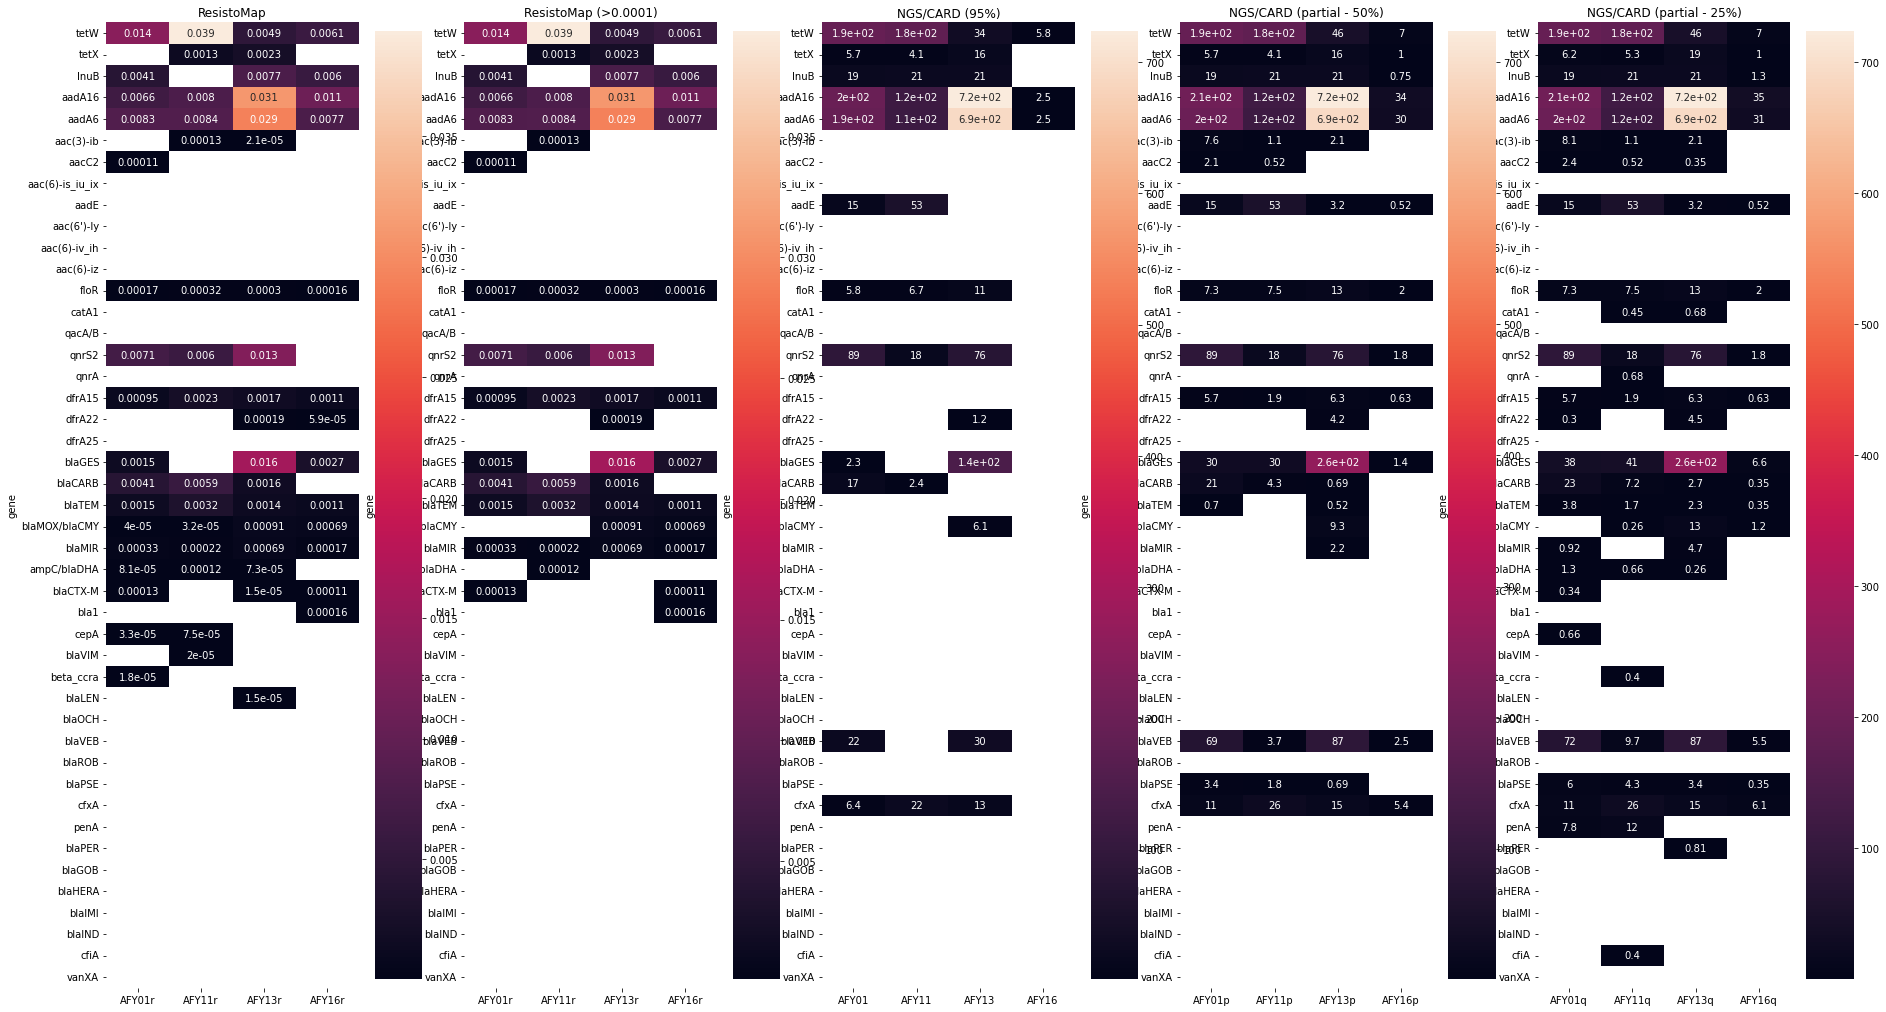

In [249]:
compRM = comp[samplesRM]
compCARD = comp[samplesCARD]
compCARD2 = comp[samplesCARD2]
compCARD3 = comp[samplesCARD3]

fig, axs = plt.subplots(1,5, figsize=(25, 14))
fig.tight_layout()
sns.heatmap(compRM, annot=True, ax=axs[0])
sns.heatmap(compRM.mask(compRM<0.0001), annot=True, ax=axs[1])
sns.heatmap(compCARD, annot=True, ax=axs[2])
sns.heatmap(compCARD2, annot=True, ax=axs[3])
sns.heatmap(compCARD3, annot=True, ax=axs[4])

axs[0].set_title("ResistoMap")
axs[1].set_title("ResistoMap (>0.0001)")
axs[2].set_title("NGS/CARD (95%)")
axs[3].set_title("NGS/CARD (partial - 50%)")
axs[4].set_title("NGS/CARD (partial - 25%)")


In [122]:
fig.savefig('1-many.svg')

### Correlation analysis for 1-many relation

Text(0.5, 1.0, 'NGS/CARD (partial - 50%)')

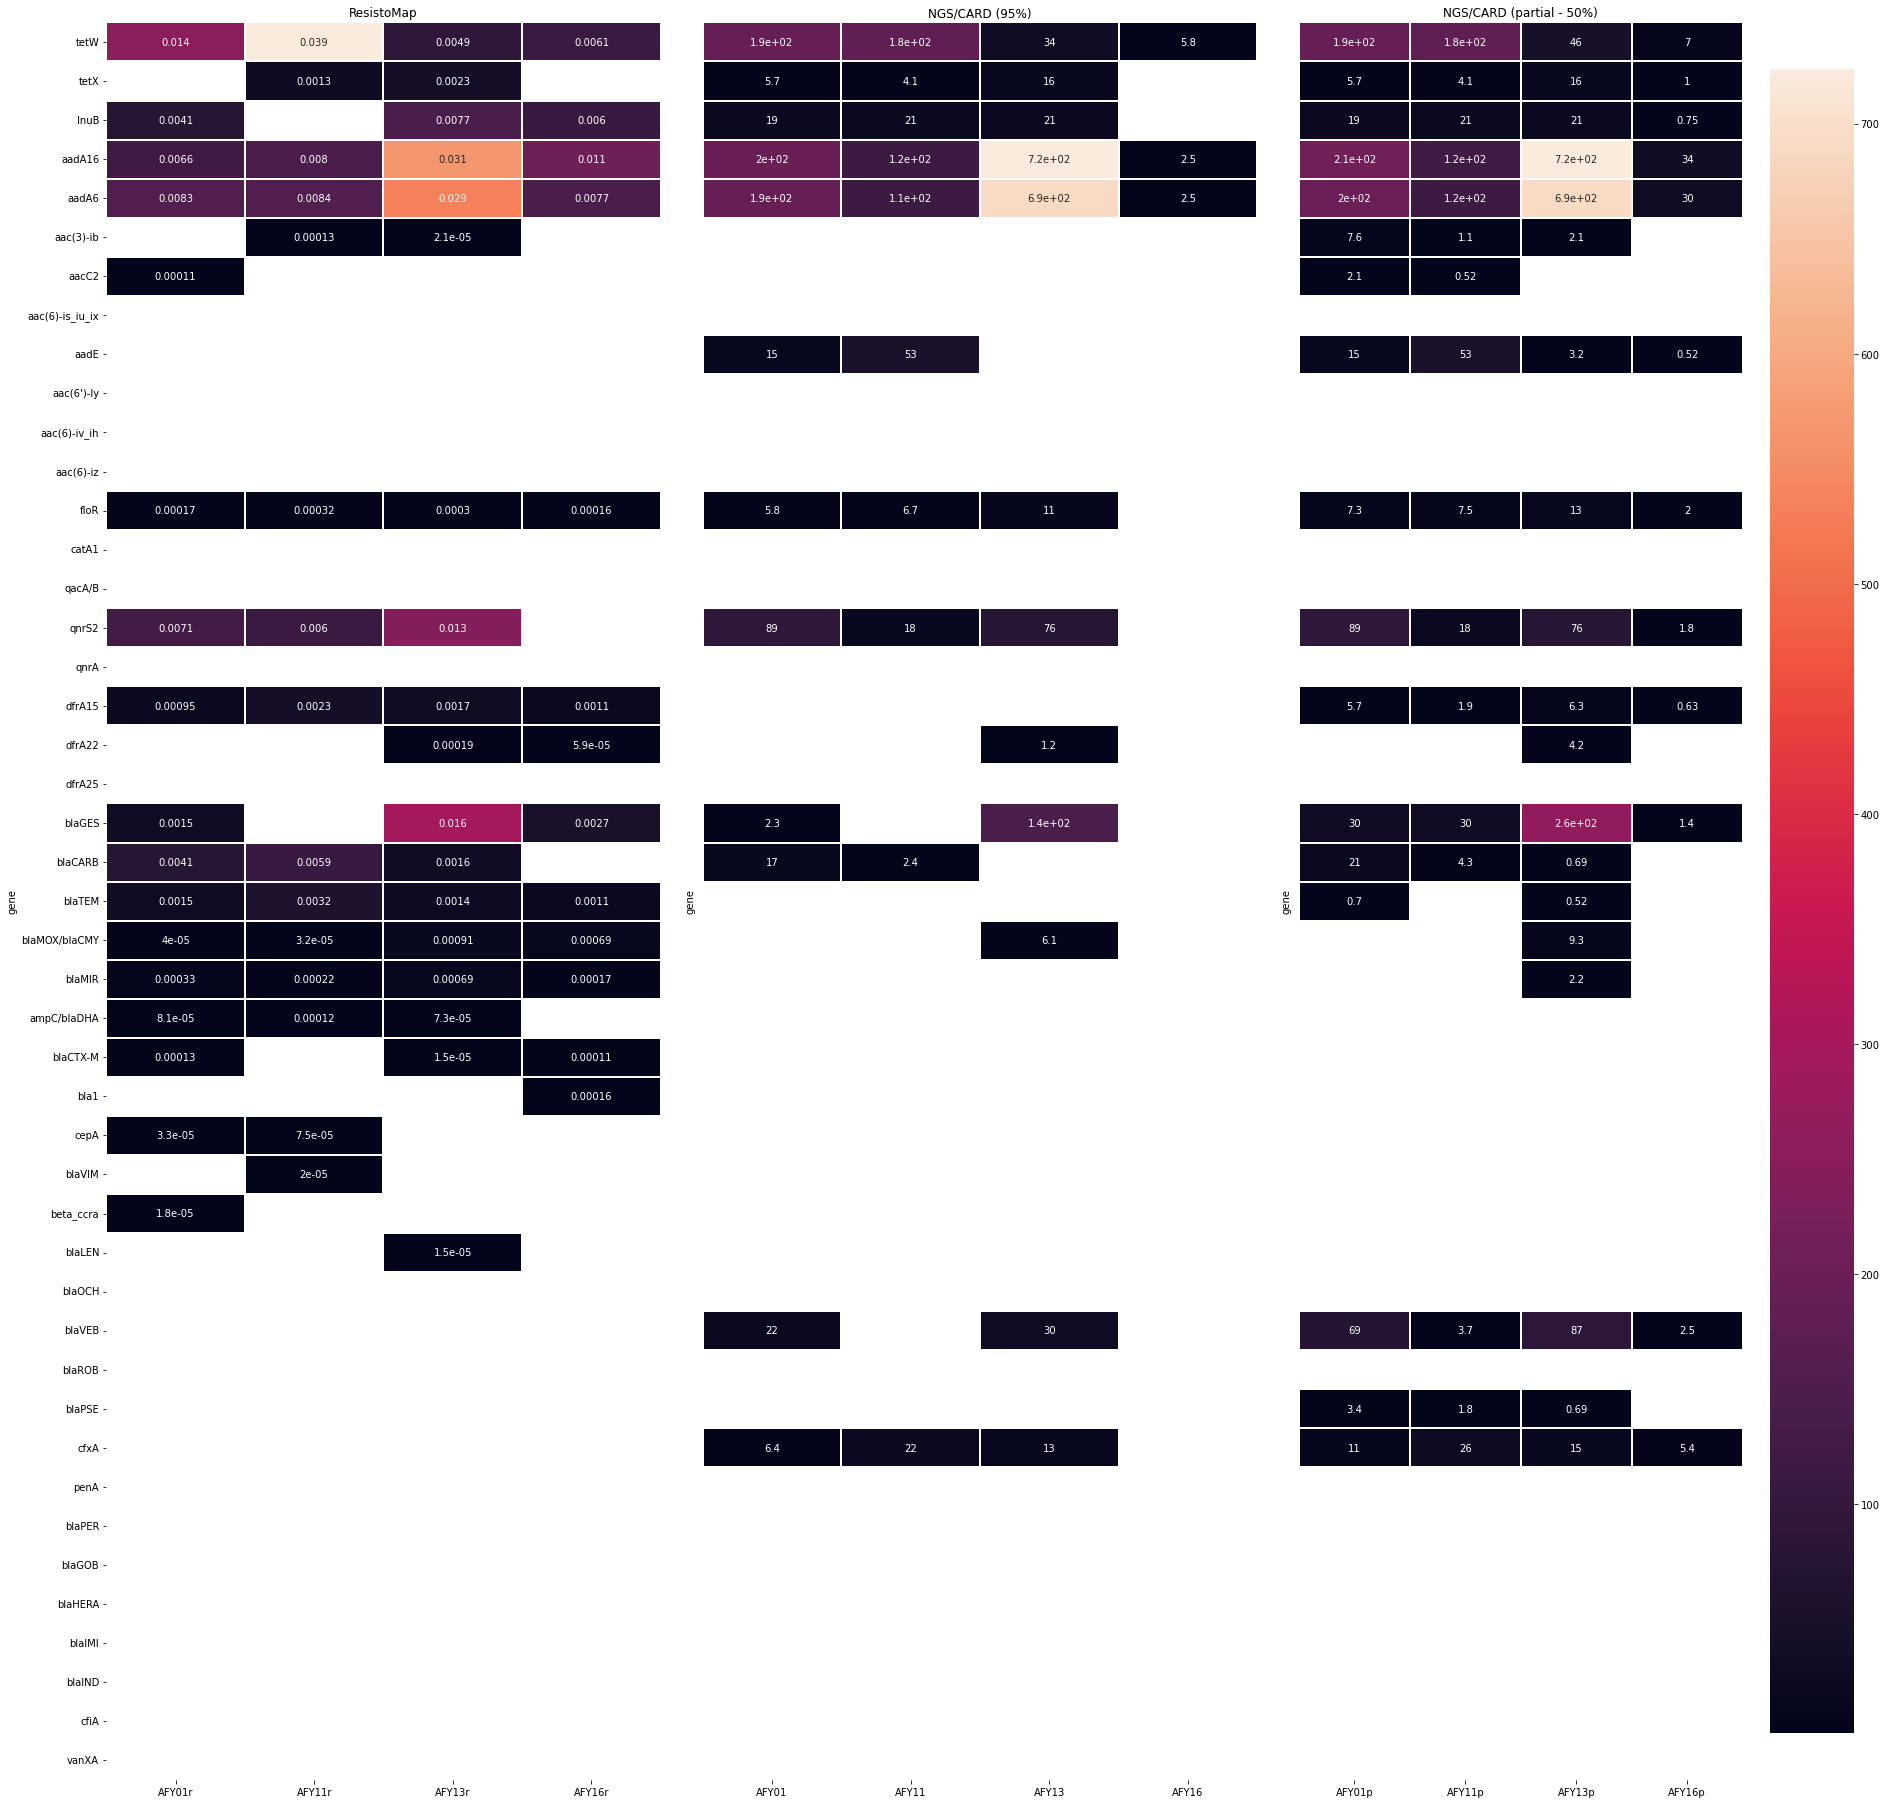

In [250]:
compRM = comp[samplesRM]
compCARD = comp[samplesCARD]
compCARD2 = comp[samplesCARD2]
compCARD3 = comp[samplesCARD3]

fig, axs = plt.subplots(1,3, figsize=(25, 25))
fig.tight_layout()
sns.heatmap(compRM, annot=True, linewidth=0.2, cbar=False,  ax=axs[0])
#sns.heatmap(compRM.mask(compRM<0.0001), annot=True, ax=axs[1])
sns.heatmap(compCARD, annot=True, linewidth=0.2, cbar=False,yticklabels=False, ax=axs[1])
sns.heatmap(compCARD2, annot=True, linewidth=0.2, yticklabels=False,ax=axs[2])
#sns.heatmap(compCARD3, annot=True, ax=axs[4])

axs[0].set_title("ResistoMap")
#axs[1].set_title("ResistoMap (>0.0001)")
axs[1].set_title("NGS/CARD (95%)")
axs[2].set_title("NGS/CARD (partial - 50%)")
#axs[4].set_title("NGS/CARD (partial - 25%)")


In [251]:
compRM

AFY01r    AFY11r    AFY13r    AFY16r
gene                                                   
tetW             0.013650  0.039373  0.004922  0.006073
tetX                  NaN  0.001314  0.002288       NaN
lnuB             0.004058       NaN  0.007750  0.005990
aadA16           0.006570  0.007995  0.030998  0.011061
aadA6            0.008344  0.008393  0.029023  0.007741
aac(3)-ib             NaN  0.000129  0.000021       NaN
aacC2            0.000112       NaN       NaN       NaN
aac(6)-is_iu_ix       NaN       NaN       NaN       NaN
aadE                  NaN       NaN       NaN       NaN
aac(6')-Iy            NaN       NaN       NaN       NaN
aac(6)-iv_ih          NaN       NaN       NaN       NaN
aac(6)-iz             NaN       NaN       NaN       NaN
floR             0.000165  0.000322  0.000300  0.000156
catA1                 NaN       NaN       NaN       NaN
qacA/B                NaN       NaN       NaN       NaN
qnrS2            0.007065  0.006038  0.012988       NaN
qnrA                  NaN       NaN       NaN       NaN
dfrA15           0.000947  0.002296  0.001704  0.001123
dfrA22                NaN       NaN  0.000185  0.000059
dfrA25                NaN       NaN       NaN       NaN
blaGES           0.001485       NaN  0.015990  0.002727
blaCARB          0.004143  0.005934  0.001612       NaN
blaTEM           0.001538  0.003202  0.001356  0.001074
blaMOX/blaCMY    0.000040  0.000032  0.000910  0.000694
blaMIR           0.000327  0.000221  0.000695  0.000171
ampC/blaDHA      0.000081  0.000118  0.000073       NaN
blaCTX-M         0.000128       NaN  0.000015  0.000108
bla1                  NaN       NaN       NaN  0.000156
cepA             0.000033  0.000075       NaN       NaN
blaVIM                NaN  0.000020       NaN       NaN
beta_ccra        0.000018       NaN       NaN       NaN
blaLEN                NaN       NaN  0.000015       NaN
blaOCH                NaN       NaN       NaN       NaN
blaVEB                NaN       NaN       NaN       NaN
blaROB                NaN       NaN       NaN       NaN
blaPSE                NaN       NaN       NaN       NaN
cfxA                  NaN       NaN       NaN       NaN
penA                  NaN       NaN       NaN       NaN
blaPER                NaN       NaN       NaN       NaN
blaGOB                NaN       NaN       NaN       NaN
blaHERA               NaN       NaN       NaN       NaN
blaIMI                NaN       NaN       NaN       NaN
blaIND                NaN       NaN       NaN       NaN
cfiA                  NaN       NaN       NaN       NaN
vanXA                 NaN       NaN       NaN       NaN

In [252]:
a0 = compRM.mask(compRM<0.0001).fillna(0).to_numpy().reshape(45*4)
a1 = compRM.fillna(0).to_numpy().reshape(45*4)
a2 = compCARD.fillna(0).to_numpy().reshape(45*4)
a3 = compCARD2.fillna(0).to_numpy().reshape(45*4)
a4 = compCARD3.fillna(0).to_numpy().reshape(45*4)
corrDF2 = pd.DataFrame(zip(a1,a0, a2,a3,a4))
corrDF2.columns = ['ResistoMap', 'ResistoMap1', 'CARD95', 'CARD50', 'CARD25']
corrDF2.corr()

ResistoMap  ResistoMap1    CARD95    CARD50    CARD25
ResistoMap     1.000000     0.999997  0.802176  0.812671  0.812521
ResistoMap1    0.999997     1.000000  0.802160  0.812667  0.812519
CARD95         0.802176     0.802160  1.000000  0.990624  0.989925
CARD50         0.812671     0.812667  0.990624  1.000000  0.999798
CARD25         0.812521     0.812519  0.989925  0.999798  1.000000

### Correlations per AMG class

In [315]:
# Other
c0=corrDF.iloc[0:4*4]
# Tetracycline
c1=pd.concat([corrDF.iloc[4*4:13*4], corrDF2.iloc[0*4:2*4]])
# MLSB
c2=pd.concat([corrDF.iloc[14*4:21*4], corrDF2.iloc[2*4:3*4]])
# Aminoglycoside
c3=pd.concat([corrDF.iloc[21*4:47*4], corrDF2.iloc[3*4:12*4]])
# Phenicol
c4=pd.concat([corrDF.iloc[46*4:57*4], corrDF2.iloc[12*4:14*4]])
# MDR
#pd.concat([corrDF.iloc[57*4:68*4], corrDF2.iloc[14*4]]).corr()
c5=corrDF.iloc[57*4:68*4].corr()
# Quinolone
c6=pd.concat([corrDF.iloc[68*4:71*4], corrDF2.iloc[14*4:17*4]])
# Trimethoprim
c7=pd.concat([corrDF.iloc[71*4:78*4], corrDF2.iloc[17*4:20*4]])
# Beta Lactam
c8=pd.concat([corrDF.iloc[78*4:83*4], corrDF2.iloc[20*4:44*4]])

corrTables = [c0,c1,c2,c3,c4,c5,c6,c7,c8]
amgClasses="Other,Tetracycline,MLSB,Aminoglycoside,Phenicol,MDR,Quinolone,Trimethoprim,Beta Lactam,Vancomycin".split(',')
corrRM_95 = [corT.loc['ResistoMap', 'CARD95'] for corT in corrTables] +[1]
corrRM_50 = [corT.loc['ResistoMap', 'CARD50'] for corT in corrTables] +[1]
corrRM_25 = [corT.loc['ResistoMap', 'CARD25'] for corT in corrTables] +[1]
corrBreakdown = pd.DataFrame([corrRM_95, corrRM_50, corrRM_25], columns=amgClasses, index='RM vs CARD95,RM vs CARD50,RM vs CARD25'.split(','))
corrBreakdown

Other  Tetracycline      MLSB  Aminoglycoside  Phenicol  \
RM vs CARD95 -0.072108      0.711904  0.774756        0.882120  0.830108   
RM vs CARD50  0.752218      0.709482  0.774864        0.888196  0.828480   
RM vs CARD25  0.749304      0.708983  0.775301        0.888394  0.828714   

                   MDR  Quinolone  Trimethoprim  Beta Lactam  Vancomycin  
RM vs CARD95 -0.088390   0.898190     -0.064634     0.853091           1  
RM vs CARD50 -0.102805   0.898600      0.282960     0.810460           1  
RM vs CARD25 -0.116883   0.898418      0.278664     0.812142           1

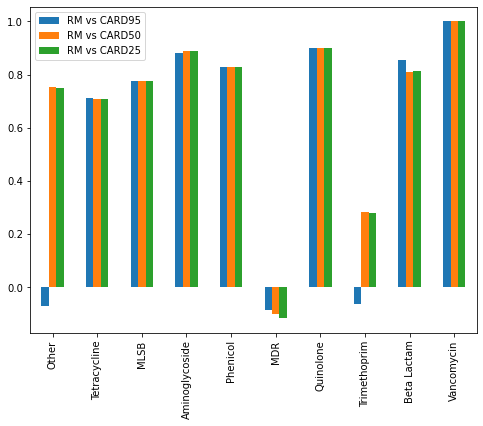

In [318]:
ax = corrBreakdown.T.plot(kind='bar', figsize=(8,6))

In [319]:
ax.get_figure().savefig('corrBreakdown.pdf')

In [324]:
from scipy.stats import pearsonr
pd.concat([corrDF.iloc[78*4:83*4], corrDF2.iloc[20*4:44*4]])

ResistoMap  ResistoMap1  CARD95  CARD50  CARD25
312    0.000020          0.0     0.0     0.0     0.0
313    0.000033          0.0     0.0     0.0     0.0
314    0.000000          0.0     0.0     0.0     0.0
315    0.000000          0.0     0.0     0.0     0.0
316    0.000000          0.0     0.0     0.0     0.0
..          ...          ...     ...     ...     ...
171    0.000000          0.0     0.0     0.0     0.0
172    0.000000          0.0     0.0     0.0     0.0
173    0.000000          0.0     0.0     0.0     0.4
174    0.000000          0.0     0.0     0.0     0.0
175    0.000000          0.0     0.0     0.0     0.0

[116 rows x 5 columns]

In [320]:
corrBreakdown.to_csv('corrBreakdown.csv', index=False)

In [297]:
# Vancomycin (all 0, correlation not defined)
#corrDF2.iloc[20*4:21*4]
c9=pd.concat([corrDF.iloc[83*4:], corrDF2.iloc[44*4:]])
#corrDF.iloc[78*4:83*4]
c9

ResistoMap  ResistoMap1  CARD95  CARD50    CARD25
332         0.0          0.0     0.0     0.0  0.000000
333         0.0          0.0     0.0     0.0  0.000000
334         0.0          0.0     0.0     0.0  0.000000
335         0.0          0.0     0.0     0.0  0.000000
336         0.0          0.0     0.0     0.0  0.000000
337         0.0          0.0     0.0     0.0  0.000000
338         0.0          0.0     0.0     0.0  0.000000
339         0.0          0.0     0.0     0.0  0.000000
340         0.0          0.0     0.0     0.0  0.000000
341         0.0          0.0     0.0     0.0  0.000000
342         0.0          0.0     0.0     0.0  0.000000
343         0.0          0.0     0.0     0.0  0.000000
344         0.0          0.0     0.0     0.0  0.000000
345         0.0          0.0     0.0     0.0  0.000000
346         0.0          0.0     0.0     0.0  0.000000
347         0.0          0.0     0.0     0.0  0.000000
348         0.0          0.0     0.0     0.0  0.000000
349         0.0          0.0     0.0     0.0  0.000000
350         0.0          0.0     0.0     0.0  0.000000
351         0.0          0.0     0.0     0.0  0.000000
352         0.0          0.0     0.0     0.0  0.000000
353         0.0          0.0     0.0     0.0  0.000000
354         0.0          0.0     0.0     0.0  0.000000
355         0.0          0.0     0.0     0.0  0.000000
356         0.0          0.0     0.0     0.0  0.000000
357         0.0          0.0     0.0     0.0  0.280505
358         0.0          0.0     0.0     0.0  0.000000
359         0.0          0.0     0.0     0.0  0.000000
360         0.0          0.0     0.0     0.0  0.000000
361         0.0          0.0     0.0     0.0  0.000000
362         0.0          0.0     0.0     0.0  0.000000
363         0.0          0.0     0.0     0.0  0.000000
364         0.0          0.0     0.0     0.0  0.000000
365         0.0          0.0     0.0     0.0  0.000000
366         0.0          0.0     0.0     0.0  0.000000
367         0.0          0.0     0.0     0.0  0.000000
368         0.0          0.0     0.0     0.0  0.000000
369         0.0          0.0     0.0     0.0  0.000000
370         0.0          0.0     0.0     0.0  0.000000
371         0.0          0.0     0.0     0.0  0.000000
176         0.0          0.0     0.0     0.0  0.000000
177         0.0          0.0     0.0     0.0  0.000000
178         0.0          0.0     0.0     0.0  0.000000
179         0.0          0.0     0.0     0.0  0.000000

In [196]:
corrDF3 = pd.concat([corrDF, corrDF2])


In [254]:
372/4

93.0

In [241]:
si = set(ngs.index)
for i,row in ndf.iterrows():
    cards = ndf.iloc[i,5:].dropna()
    isec = si.intersection(set(cards))
    if len(isec)>0:
        print(list(row.iloc[1:7]), len(isec), len(cards))

['16S new 2', nan, nan, nan, 3003223, 3003481] 44 44
['blaMOX/blaCMY', nan, nan, nan, 3002012, 3002020] 1 15
['blaVEB', 'VEB-', 'VEB', 'veb', 3002372, 3002375] 8 27
['blaOXA_44old', 'OXA-', 'OXA', 'oxa', 3001502, 3001429] 20 41
['blaOXA10_45old', 'OXA-', 'OXA', 'oxa', 3001502, 3001429] 20 41
['cphA', nan, nan, nan, 3003094, 3003095] 1 8
['cphA_47old', nan, nan, nan, 3003094, 3003100] 1 6
['floR_56old', nan, nan, nan, 3002812, 3002705] 1 2
['lnuB_67old', 'l', 'l', 'l', 3003206, 3002836] 2 3
['lnuB_68old', 'l', 'l', 'l', 3003206, 3002836] 2 3
["aac(6')-Ib_94old", 'A', nan, 'a', 3002600, 3002591] 4 19
["aac(6')-Ib", 'A', nan, 'a', 3002600, 3002591] 4 20
['aadA_96old', nan, nan, nan, 3002620, 3002612] 9 9
['aadA2', 'aadA', 'aadA', 'aada', 3003197, 3002602] 5 6
['aadA_99', nan, nan, nan, 3002620, 3002612] 9 9
['aadA5_100old', 'aadA', 'aadA', 'aada', 3002604, 3002605] 2 3
['aadA2_101old', 'aadA', 'aadA', 'aada', 3003197, 3002602] 5 6
['cfxA', 'CfxA', 'fxA', 'cfxa', 3003002, 3003005] 5 6
['bl

In [230]:
list(row)[:4]

[138, 'qnrB46,47,48', 'QnrB', 'nrB']

In [ ]:
## pedestrian joining
data = []

header = ['group', 'gene', 'assay'] + samplesRM + samplesCARD + samplesCARD2
for i,row in ndf.iterrows():
    gene = row["RM"]
    match = rm1[rm1["Gene target"]==gene]

    if match.shape[0]==1: ## unique match (should be, it is rm1)
        card = match.iloc[0,-1]
        rec = list(row)
        for ngsDF in [ngs, ngs50]:            
            if card in ngsDF.index:
                rec += list(ngsDF.loc[card])
            else:
                rec += [None]*4
        data.append(rec)
        

comp = pd.DataFrame(data, columns=header) #.fillna(0)
comp.set_index('gene', inplace=True)

### Identifying gene name overlap
using some dedicated functions for substring search

In [45]:
## Manually identified overlap
overlap = """aac(3)-ib	AAC(3)-Ib
aac(6')-II	AAC(6')-Ii
aadA10	aadA10
aadA16	aadA16
aadA6	aadA6
acrF	AcrF
adeI	adeI
catB2	catB2
catB8	catB8
catP	catP
catQ	catQ
dfrA12	dfrA12
dfrA15	dfrA15
dfra17	dfrA17
dfra21	dfrA21
dfrA22	dfrA22
dfrA27	dfrA27
ereA	EreA
ermF	ErmF
floR	floR
lnuB	lnuB
lnuC	lnuC
lnuF	lnuF
lsaC	lsaC
mdtA	mdtA
mdtE	mdtE
mdtH	mdtH
mexA	MexA
mexB	MexB
mexE	MexE
mphA	mphA
msrE	msrE
oqxA	oqxA
qnrB4	QnrB4
qnrS2	QnrS2
tet32	tet32
tetM	tetM
tetQ	tetQ
tetR	tetR
tetT	tetT
tetW	tetW
tetX	tetX""".split('\n')
overlapDict = dict(genepair.split('\t') for genepair in overlap)
for k,v in overlapDict.items():
    if k!=v: print(k,v)

aac(3)-ib AAC(3)-Ib
aac(6')-II AAC(6')-Ii
acrF AcrF
dfra17 dfrA17
dfra21 dfrA21
ereA EreA
ermF ErmF
mexA MexA
mexB MexB
mexE MexE
qnrB4 QnrB4
qnrS2 QnrS2


In [53]:
def strip(gene):
    return ''.join([ch.lower() for ch in gene if not ch in ['"',"'"]+list("-_(),.") ])

genemap = {}
for rgene in allResistomap:
    for ngsgene in card:
        if strip(rgene) == strip(ngsgene):
            #print(rgene, ngsgene, end='')
            genemap[rgene] = ngsgene
            #if rgene!=ngsgene: print('       ***')
genemap, len(genemap)

({'tetG': 'tet(G)',
  'tetM': 'tetM',
  'lnuB': 'lnuB',
  'ermF': 'ErmF',
  'tetR': 'tetR',
  'mefB': 'mef(B)',
  'ant6-ia': 'ANT(6)-Ia',
  'aadA1_2': 'aadA12',
  'ereA': 'EreA',
  'aadA10': 'aadA10',
  'catB3': 'catB3',
  'aadA6': 'aadA6',
  'tet32': 'tet32',
  'mexB': 'MexB',
  'tetS': 'tetS',
  'mphA': 'mphA',
  'bacA': 'bacA',
  'dfrG': 'dfrG',
  'aph3-ib': "APH(3'')-Ib",
  'catB8': 'catB8',
  'dfra17': 'dfrA17',
  'sul4': 'sul4',
  'oqxA': 'oqxA',
  'dfrA22': 'dfrA22',
  'tet39': 'tet(39)',
  'mdtH': 'mdtH',
  'tetQ': 'tetQ',
  'aadA16': 'aadA16',
  'tetX': 'tetX',
  'arr2': 'arr-2',
  'qnrS2': 'QnrS2',
  'floR': 'floR',
  'lnuF': 'lnuF',
  'catQ': 'catQ',
  'aadA2_3': 'aadA23',
  'ant6-ib': 'ANT(6)-Ib',
  'sat4': 'SAT-4',
  'mdtE': 'mdtE',
  'dfrA7': 'dfrA7',
  'lnuC': 'lnuC',
  'aadA2_1': 'aadA21',
  'mdtA': 'mdtA',
  'aadA7': 'aadA7',
  'msrE': 'msrE',
  'cfxA': 'CfxA',
  'acrF': 'AcrF',
  'tetW': 'tetW',
  'arr3': 'arr-3'},
 48)

In [51]:
for k,v in genemap.items():
    if k!=v: print(k,v)

sat4 SAT-4
tetG tet(G)
aph3-ib APH(3'')-Ib
dfra17 dfrA17
ermF ErmF
mefB mef(B)
aadA2_1 aadA21
ant6-ia ANT(6)-Ia
aadA1_2 aadA12
tet39 tet(39)
ereA EreA
aadA2_3 aadA23
ant6-ib ANT(6)-Ib
acrF AcrF
mexB MexB
arr2 arr-2
qnrS2 QnrS2


In [ ]:
qnrB4

In [18]:
countExact = 0
countCaseIns = 0
for pair in overlap:
    rm, card = pair.split('\t')
    if rm==card: 
        print("EXACT MATCH:", rm, card)
        countExact += 1
    elif rm.lower()==card.lower(): 
        print("CASE INS. M:", rm, card)
        countCaseIns += 1
countExact, countCaseIns
        

CASE INS. M: aac(3)-ib AAC(3)-Ib
CASE INS. M: aac(6')-II AAC(6')-Ii
EXACT MATCH: aadA10 aadA10
EXACT MATCH: aadA16 aadA16
EXACT MATCH: aadA6 aadA6
CASE INS. M: acrF AcrF
EXACT MATCH: adeI adeI
EXACT MATCH: catB2 catB2
EXACT MATCH: catB8 catB8
EXACT MATCH: catP catP
EXACT MATCH: catQ catQ
EXACT MATCH: dfrA12 dfrA12
EXACT MATCH: dfrA15 dfrA15
CASE INS. M: dfra17 dfrA17
CASE INS. M: dfra21 dfrA21
EXACT MATCH: dfrA22 dfrA22
EXACT MATCH: dfrA27 dfrA27
CASE INS. M: ereA EreA
CASE INS. M: ermF ErmF
EXACT MATCH: floR floR
EXACT MATCH: lnuB lnuB
EXACT MATCH: lnuC lnuC
EXACT MATCH: lnuF lnuF
EXACT MATCH: lsaC lsaC
EXACT MATCH: mdtA mdtA
EXACT MATCH: mdtE mdtE
EXACT MATCH: mdtH mdtH
CASE INS. M: mexA MexA
CASE INS. M: mexB MexB
CASE INS. M: mexE MexE
EXACT MATCH: mphA mphA
EXACT MATCH: msrE msrE
EXACT MATCH: oqxA oqxA
CASE INS. M: qnrB4 QnrB4
CASE INS. M: qnrS2 QnrS2
EXACT MATCH: tet32 tet32
EXACT MATCH: tetM tetM
EXACT MATCH: tetQ tetQ
EXACT MATCH: tetR tetR
EXACT MATCH: tetT tetT
EXACT MATCH: t

(30, 12)

In [29]:
def startswith(substring, el):
    for word in el.split():
        if word.lower().startswith(substring.lower()): return True
    return False
def subgroupCompare(substring, set1, set2):
    print('-'*200)
    print('***', substring, '***')
    print(", ".join(sorted([el for el in set1 if substring.lower() in el.lower() and len(el)<20])))
    print('---')
    print(", ".join(sorted([el for el in set2 if substring.lower() in el.lower() and (len(el)<20 or startswith(substring, el))])))
    #print('-'*200)
        
#res = res[res.group!='Taxanomic']
#res = res[res.group!='16S rRNA']        
resistome = set(res.index)

#### Naive exact match

In [32]:
card = list(ngs.index)
isec = resistome.intersection(card) 
print(f"Intersection ({len(isec)})", isec)

#### Case insensitive, special-char insensitive match

ARO Term  ARO Accession  \
1                                                  dfrF        3002867   
6                                                  lnuA        3002835   
9                                                  msrE        3003109   
10                                                FosA2        3002804   
13                                                 mdtP        3003550   
...                                                 ...            ...   
1271  Bifidobacterium adolescentis rpoB mutants conf...        3004480   
1279                          vanR gene in vanO cluster        3002930   
1282                                            Erm(51)        3007033   
1283                                               mefH        3007047   
1289                         Neisseria gonorrhoeae rpld        3004956   

       Reference Model Type Reference DB  Alleles with Mapped Reads  \
1     protein homolog model         CARD                          1   
6     protein homolog model         CARD                          1   
9     protein homolog model         CARD                          1   
10    protein homolog model         CARD                          1   
13    protein homolog model         CARD                          1   
...                     ...          ...                        ...   
1271  protein homolog model         CARD                          1   
1279  protein homolog model         CARD                          1   
1282  protein homolog model         CARD                          1   
1283  protein homolog model         CARD                          1   
1289  protein variant model         CARD                          1   

      Reference Allele(s) Identity to CARD Reference Protein (%)  \
1                                                 100.0            
6                                                 100.0            
9                                                 100.0            
10                                                100.0            
13                                                100.0            
...                                                 ...            
1271                                              100.0            
1279                                              100.0            
1282                                              100.0            
1283                                              100.0            
1289                                              100.0            

     Resistomes & Variants: Observed in Genome(s)  \
1                                         no data   
6                                         no data   
9                                         no data   
10                                        no data   
13                                        no data   
...                                           ...   
1271                                      no data   
1279                                      no data   
1282                                      no data   
1283                                      no data   
1289                                      no data   

     Resistomes & Variants: Observed in Plasmid(s)  \
1                                          no data   
6                                          no data   
9                                          no data   
10                                         no data   
13                                         no data   
...                                            ...   
1271                                       no data   
1279                                       no data   
1282                                       no data   
1283                                       no data   
1289                                       no data   

     Resistomes & Variants: Observed Pathogen(s)  Completely Mapped Reads  \
1                          Enterococcus faecalis                     31.0   
6                    Staphylococcus haemolyticus

In [ ]:
#ngs = loadDF('01')
#card = set(ngs['ARO Term'])
subgroupCompare('erm', resistome, card)
subgroupCompare('tet', resistome, card)
subgroupCompare('aac', resistome, card)
subgroupCompare('acr', resistome, card)
subgroupCompare('ant', resistome, card)
subgroupCompare('aad', resistome, card)
subgroupCompare('van', resistome, card)

### Comparing gene groups (based on their substring matches)

<AxesSubplot:>

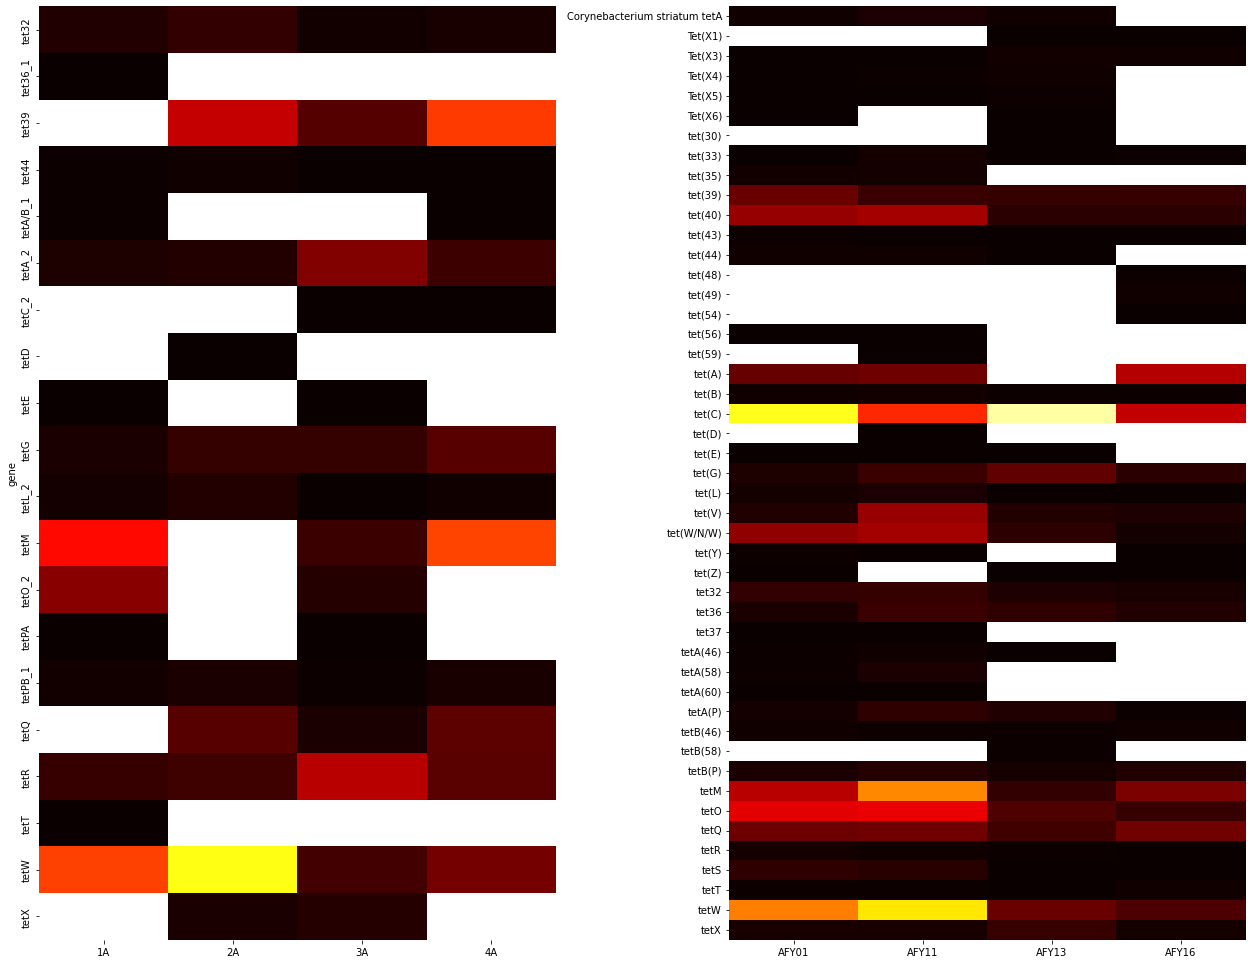

In [86]:
gen='tet'
cmap='hot'
ngsSel = ngs[ngs.index.str.contains(gen, case=False)].sort_index()
ngsSel = ngsSel[~ngsSel.index.str.contains('conferring', case=False)]
resnSel = resn[resn.index.str.contains(gen,case=False)].sort_index()
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)
sns.heatmap(resnSel, cmap=cmap, ax=ax1, cbar=False)
sns.heatmap(ngsSel, cmap=cmap, ax=ax2, cbar=False)

In [57]:
ngsSel.loc['tetM']

AFY01     853.0
AFY11    1409.0
AFY13     182.0
AFY16     129.0
Name: tetM, dtype: float64

In [81]:
resn.head()

1A        2A        3A        4A
gene                                                 
Firmicutes     0.145933  0.306949  0.079372  0.170438
Bacteroidetes  0.038386  0.062474  0.039962  0.067171
A. baumannii   0.000012       NaN       NaN       NaN
P. aeruginosa  0.000006       NaN       NaN       NaN
intI1_2        0.020570  0.019655  0.045116  0.020722

In [42]:
df1 = res[res.index.isin(isec)].sort_index()
df2 = ngs[ngs.index.isin(isec)].sort_index()
df1.join(df2)

Empty DataFrame
Columns: [group, gene, assay, 1A, 2A, 3A, 4A, AFY01, AFY11, AFY13, AFY16]
Index: []

In [88]:
df1.join(df2).to_excel('intersection_resistome_ngsCov.xlsx')

In [90]:
!pwd

/home/ahenschel/AMG_Metagenomes_AhmedY/ResistomeComparison


In [41]:
overlap = df1.join(df2)
plt.rcParams["figure.figsize"] = [17.50, 13.50]
plt.rcParams["figure.autolayout"] = True
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)
sns.heatmap(overlap["1A 2A 3A 4A".split()], cmap="jet", ax=ax1, cbar=False)
sns.heatmap(overlap["AFY01 AFY11 AFY13 AFY16".split()], cmap="jet", ax=ax2, cbar=False)

ax2.yaxis.tick_right()

fig.subplots_adjust(wspace=0.001)
plt.show()

NameError: name 'df1' is not defined

In [48]:
!pwd

/home/ahenschel/AMG_Metagenomes_AhmedY


In [64]:
res.to_excel('resistome.xlsx')


In [34]:
print(' '.join(sorted(resistome, key=lambda x:x.lower())))
print('*'*100)
card1 = [el for el in card if len(el)<20]
print(' '.join(sorted(card1, key=lambda x:x.lower())))
card2 = [el for el in card if len(el)>=20]
for el in sorted(card2):
    print(el)

16S rRNA A. baumannii aac(3)-ib aac(3)-id_ie aac(3)-iid_iia aac(3)-xa_1 aac(6')-Ib_1 aac(6')-II aac(6')-Iy aac(6')I1 aac(6)-ig aac(6)-iic aac(6)-ij aac(6)-im aac(6)-ir aac(6)-is_iu_ix aac(6)-iv_ih aac(6)-iw aac(6)-iz aac3-IVa aac6-aph2 aacA/aphD aacA43 aacC2 aacC4 aadA10 aadA16 aadA1_2 aadA2_1 aadA2_3 aadA5_2 aadA6 aadA7 aadA9_1 aadA_1 aadB aadD aadE acrA_1 acrB_1 acrF acrR_1 adeA adeI ampC/blaDHA ampC_cefa ant4-ib ant6-ia ant6-ib aph(2')-Ib aph(3'')-ia aph3-ib aph3-iii aph3-via aph3-viia aph4-ia aph4-ib aph6-ia aph9-ia aph_viii aphA1/7 aphA3_1 apmA armA_1 armA_2 arr2 arr3 arsA bacA Bacteroidetes beta_B2 beta_ccra bexA/norM bl1acc bla-L1 bla1 blaACC blaACT blaADC-nonmobile blaB blaBEL-nonmobile blaCARB blaCMY_2 blaCTX-M blaCTX-M_5 blaCTX-M_8 blaFOX blaGES blaGOB blaHERA blaIMI blaIND blaKPC blaLEN blaMIR blaMOX/blaCMY blaNDM blaOCH blaOXA48 blaOXA51 blaOXY blaOXY1 blaPAO blaPER blaPSE blaROB blaSFO blaSHV11 blaSME blaTEM blaTLA blaVEB blaVIM blaZ cadC Campylobacter carB cat cat(pC221) 

In [167]:
res.iloc[:,-4:].sum()
print(', '.join(list(set(res.group))))

Sulfonamide, Aminoglycoside, MLSB, Trimethoprim, Integrons, Vancomycin, 16S rRNA, Other, Beta Lactam, Tetracycline, MDR, Taxanomic, Phenicol, Quinolone, MGE


In [174]:
Counter(geneQC['AMR Gene Family']).most_common()

[('resistance-nodulation-cell division (RND) antibiotic efflux pump', 37),
 ('major facilitator superfamily (MFS) antibiotic efflux pump', 34),
 ('tetracycline-resistant ribosomal protection protein', 10),
 ('Erm 23S ribosomal RNA methyltransferase', 9),
 ('23S rRNA with mutation conferring resistance to macrolide antibiotics', 7),
 ('fluoroquinolone resistant gyrA', 6),
 ('trimethoprim resistant dihydrofolate reductase dfr', 5),
 ("ANT(3'')", 5),
 ('pmr phosphoethanolamine transferase', 5),
 ('ATP-binding cassette (ABC) antibiotic efflux pump', 5),
 ('General Bacterial Porin with reduced permeability to beta-lactams', 5),
 ('lincosamide nucleotidyltransferase (LNU)', 4),
 ('ANT(6)', 4),
 ('macrolide esterase', 4),
 ('rifamycin-resistant beta-subunit of RNA polymerase (rpoB)', 4),
 ('chloramphenicol acetyltransferase (CAT)', 3),
 ('OXA beta-lactamase', 3),
 ('sulfonamide resistant sul', 3),
 ('major facilitator superfamily (MFS) antibiotic efflux pump; resistance-nodulation-cell divisi

In [173]:
dc = geneQC[geneQC['AMR Gene Family'].str.contains('lactamase')]
Counter(dc['Drug Class'])

Counter({'cephamycin': 1,
         'carbapenem; cephalosporin; penam': 3,
         'penam': 2,
         'cephalosporin; penam': 2,
         'cephalosporin; penam; penem': 1})

In [104]:
def pie(table, criterion, minCount=1, height=800, width=1200):
    taxa = Counter(table[criterion])
    taxaDF = pd.Series(taxa).reset_index(name='count')
    taxaDF = taxaDF[taxaDF['count']>1]
    taxaDF['angle'] = taxaDF['count']/taxaDF['count'].sum() * 2*pi
    taxaDF = taxaDF.sort_values('count', ascending=False)
    f=(len(taxaDF)//20)+1 ## make f copies of palette
    taxaDF['color'] =(Category20c[20]*f)[:len(taxaDF)]

    p = figure(height=height, width=width,title=criterion, toolbar_location=None,
               tools="hover", tooltips="@index: @count", x_range=(-0.5, 2.0))
    p.wedge(x=0, y=1, radius=0.4,
            start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
            line_color="white", legend_field='index', fill_color='color', source=taxaDF)
    #p.axis.axis_label = None
    #p.axis.visible = False
    #p.grid.grid_line_color = None
    show(p)
    return taxaDF
    
tbl = pie(geneQC, 'AMR Gene Family', minCount=0, height=900, width=2400)

In [14]:
tbl = pie(geneQC, 'Resistomes & Variants: Observed Pathogen(s)', width=1200)

index  count     angle  \
5   resistance-nodulation-cell division (RND) anti...     37  1.243197   
4   major facilitator superfamily (MFS) antibiotic...     34  1.142397   
9   tetracycline-resistant ribosomal protection pr...     10  0.335999   
10            Erm 23S ribosomal RNA methyltransferase      9  0.302399   
0   trimethoprim resistant dihydrofolate reductase...      7  0.235199   
53  23S rRNA with mutation conferring resistance t...      7  0.235199   
39                     fluoroquinolone resistant gyrA      6  0.201600   
52  ATP-binding cassette (ABC) antibiotic efflux pump      5  0.168000   
11                pmr phosphoethanolamine transferase      5  0.168000   
6                                            ANT(3'')      5  0.168000   
54  General Bacterial Porin with reduced permeabil...      5  0.168000   
35  rifamycin-resistant beta-subunit of RNA polyme...      4  0.134400   
15                                             ANT(6)      4  0.134400   
18                                 macrolide esterase      4  0.134400   
1            lincosamide nucleotidyltransferase (LNU)      4  0.134400   
43                     fluoroquinolone resistant parE      3  0.100800   
41                          elfamycin resistant EF-Tu      3  0.100800   
37  ATP-binding cassette (ABC) antibiotic efflux p...      3  0.100800   
22                 macrolide phosphotransferase (MPH)      3  0.100800   
19  major facilitator superfamily (MFS) antibiotic...      3  0.100800   
16                          sulfonamide resistant sul      3  0.100800   
12                                 OXA beta-lactamase      3  0.100800   
7             chloramphenicol acetyltransferase (CAT)      3  0.100800   
56  small multidrug resistance (SMR) antibiotic ef...      3  0.100800   
32                           ampC-type beta-lactamase      2  0.067200   
27                                            AAC(6')      2  0.067200   
42  ATP-binding cassette (ABC) antibiotic efflux p...      2  0.067200   
44  ATP-binding cassette (ABC) antibiotic efflux p...      2  0.067200   
47              antibiotic-resistant murA transferase      2  0.067200   
51                     fluoroquinolone resistant parC      2  0.067200   
2                              msr-type ABC-F protein      2  0.067200   

      color  
5   #3182bd  
4   #6baed6  
9   #9ecae1  
10  #c6dbef  
0   #e6550d  
53  #fd8d3c  
39  #fdae6b  
52  #fdd0a2  
11  #31a354  
6   #74c476  
54  #a1d99b  
35  #c7e9c0  
15  #756bb1  
18  #9e9ac8  
1   #bcbddc  
43  #dadaeb  
41  #636363  
37  #969696  
22  #bdbdbd  
19  #d9d9d9  
16  #3182bd  
12  #6baed6  
7   #9ecae1  
56  #c6dbef  
32  #e6550d  
27  #fd8d3c  
42  #fdae6b  
44  #fdd0a2  
47  #31a354  
51  #74c476  
2   #a1d99b

In [94]:
pie(geneQC, 'Resistance Mechanism')

index  count     angle  \
3                                   antibiotic efflux     79  2.167562   
5                        antibiotic target alteration     63  1.728562   
1                             antibiotic inactivation     43  1.179812   
2                        antibiotic target protection     13  0.356687   
0                       antibiotic target replacement     10  0.274375   
4     antibiotic target alteration; antibiotic efflux      8  0.219500   
7   antibiotic target alteration; antibiotic targe...      4  0.109750   
11                 reduced permeability to antibiotic      4  0.109750   
10  reduced permeability to antibiotic; resistance...      3  0.082312   
8   antibiotic target alteration; antibiotic efflu...      2  0.054875   

      color  
3   #3182bd  
5   #6baed6  
1   #9ecae1  
2   #c6dbef  
0   #e6550d  
4   #fd8d3c  
7   #fdae6b  
11  #fdd0a2  
10  #31a354  
8   #74c476

In [95]:
## Note: QC filtering changed the picture substantially
Counter(gene['Resistance Mechanism']).most_common(10)

[('antibiotic inactivation', 660),
 ('antibiotic target alteration', 269),
 ('antibiotic efflux', 217),
 ('antibiotic target protection', 61),
 ('antibiotic target alteration; antibiotic efflux', 27),
 ('antibiotic target replacement', 24),
 ('reduced permeability to antibiotic', 9),
 ('antibiotic target alteration; antibiotic target replacement', 8),
 ('reduced permeability to antibiotic; resistance by absence', 8),
 ('antibiotic efflux; reduced permeability to antibiotic', 4)]

In [ ]:
heatmap = pd.DataFrame([extractHeatmapData(sid, col2='coverage', mapqThr=0, pCovThr = 50, mappedReadThr=0, log=False) for sid in sampleIDs]).transpose()

heatmap.columns = samples = [f'AFY{sid}' for sid in sampleIDs]